
# **Title**: DeepNeuroPred: Advancing Neuropeptide Classification.

```
Group 5: Avi Vyas, D Veera Harsha Vardhan Reddy, Godavarthi Sai Nikhil, Sarthak Jindal
```

## Selected Paper:
Lei Wang et al. (2023). NeuroPred-PLM: an interpretable and robust model for neuropeptide prediction by protein language model. Briefings in Bioinformatics, 24(2), 1-9. [DOI: 10.1093/bib/bbad077] (https://doi.org/10.1093/bib/bbad077).



# Introduction

This project implements a **Protein Language Model (PLM)** using transformer layers for the classification of neuropeptide sequences. The model leverages the self-attention mechanism from transformers to capture long-range dependencies in the sequence data. This approach is particularly useful for tasks involving protein sequences, where positional information and global context are crucial.


```
Input → Embedding → Transformers → Projection → Convolution → Attention → Fully Connected → Output.

```



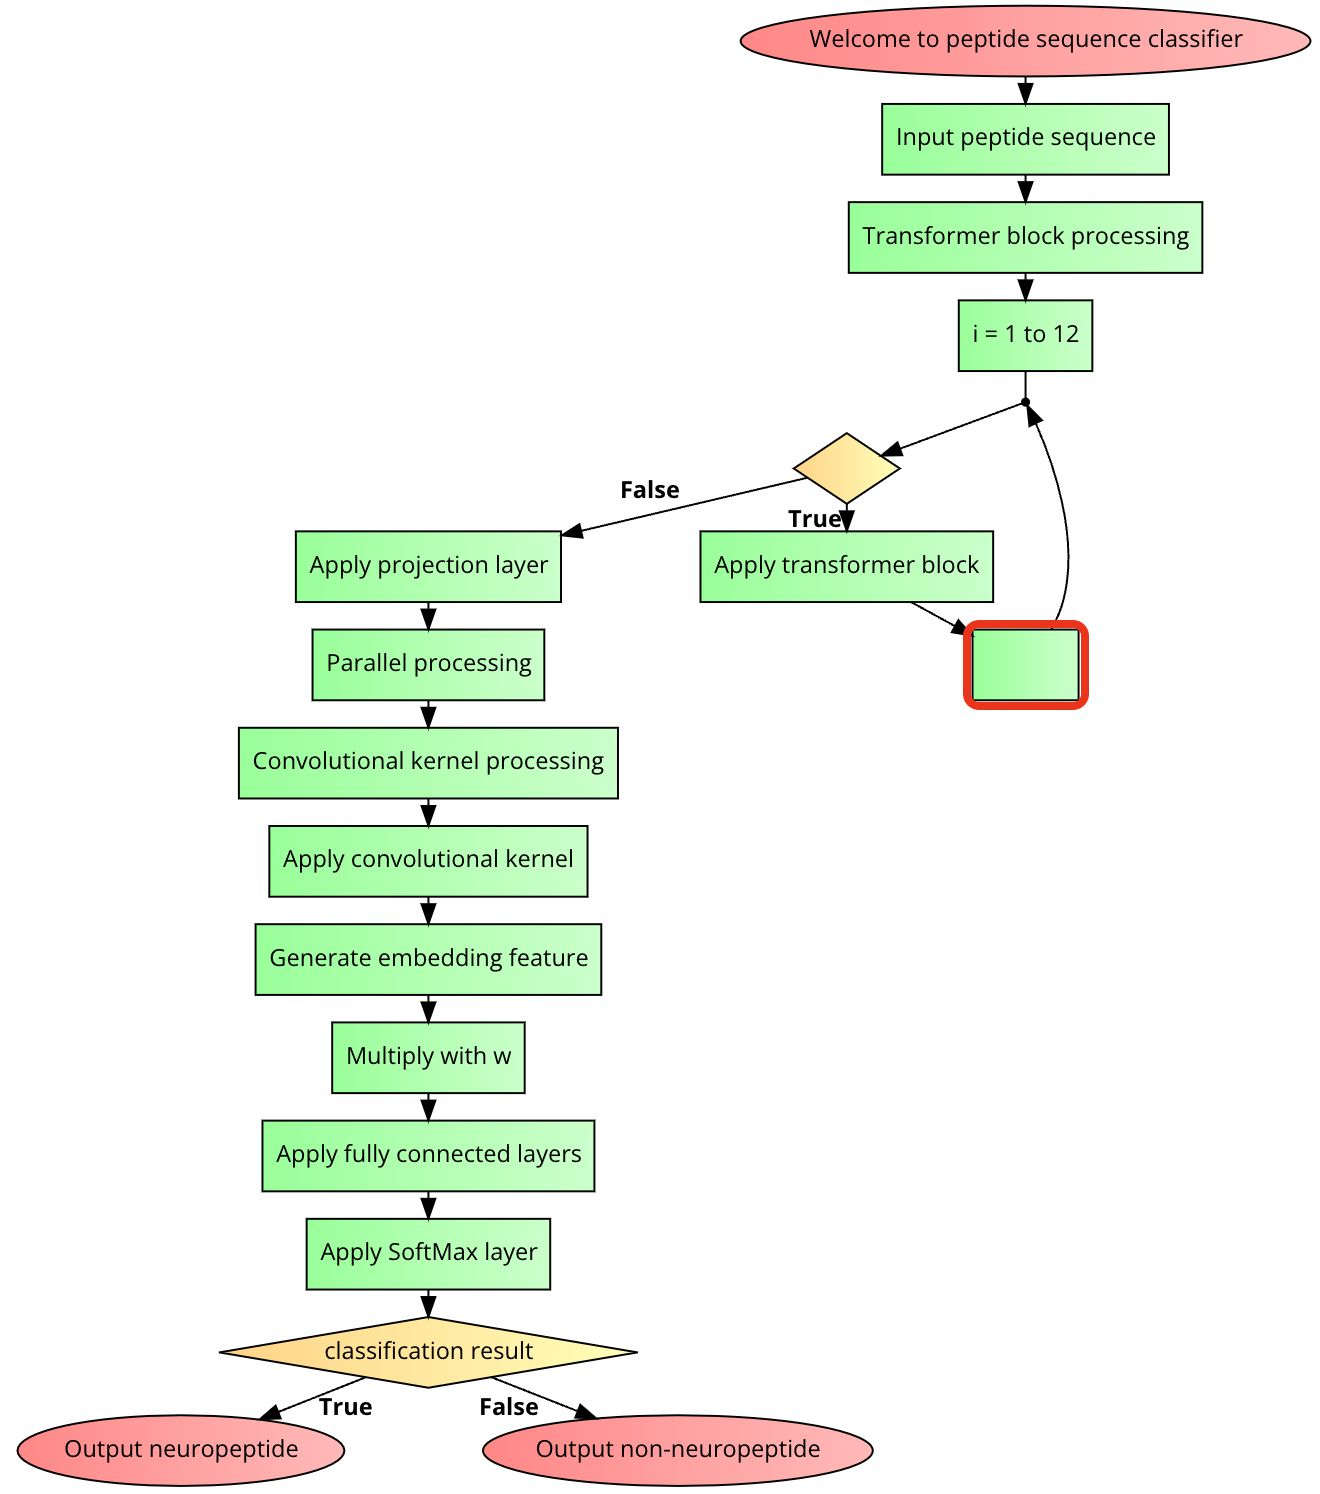

In [1]:
!pip install einops transformers scikit-learn torchsummary

In [3]:
import torch
import pandas as pd
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from einops import rearrange
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AdamW
import matplotlib.pyplot as plt
from tabulate import tabulate
from torchsummary import summary
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE

# Data Loading

* **Training and Testing Data:** The data consists of protein sequences stored in a CSV format. Each row represents a sequence and its corresponding label.

* **Tokenizer:** We use the AutoTokenizer from Hugging Face's transformers library to tokenize the protein sequences. Specifically, the pre-trained model facebook/esm2_t33_650M_UR50D is used for tokenization.

In [ ]:
# Function to load sequences from files
def load_sequences(pos_file_path, neg_file_path):
    with open(pos_file_path, 'r') as pos_file:
        positive_sequences = pos_file.read().splitlines()

    with open(neg_file_path, 'r') as neg_file:
        negative_sequences = neg_file.read().splitlines()

    print(f"Count of positive sequences: {len(positive_sequences)}")
    print(f"Count of negative sequences: {len(negative_sequences)}")

    # Label sequences (1 for positive, 0 for negative)
    positive_data = [(seq, 1) for seq in positive_sequences]
    negative_data = [(seq, 0) for seq in negative_sequences]

    return positive_data + negative_data

# Function to shuffle and save DataFrame to CSV
def save_data_to_csv(data, output_path):
    random.shuffle(data)
    df = pd.DataFrame(data, columns=['seq', 'label'])
    df.to_csv(output_path, index=False)
    print(f"\n{output_path} has been created successfully!")
    print(f"Total sequences in {output_path}: {len(df)}")
    print(df.head(), "\n")
    return df

In [ ]:
# Load, shuffle, and save training data
train_data = load_sequences('/content/Positive-training.txt', '/content/Negative-training.txt')
train_df = save_data_to_csv(train_data, 'train.csv')

# Load, shuffle, and save test data
test_data = load_sequences('/content/Positive-independent.txt', '/content/Negative-independent.txt')
test_df = save_data_to_csv(test_data, 'test.csv')

Count of positive sequences: 1940
Count of negative sequences: 1940

train.csv has been created successfully!
Total sequences in train.csv: 3880
                                         seq  label
0                                  KFCPEGKCV      0
1                            RPEEIGAGDQGHMFG      0
2               DDNGKPYVLPSVRTCGFDFTGAVEDISK      0
3                                  SDYLQLARG      1
4  SYSMEHFRWGKPIGHKRRPIKVYASSLEGGDSSEGTFPLQA      1 

Count of positive sequences: 495
Count of negative sequences: 495

test.csv has been created successfully!
Total sequences in test.csv: 990
                                                 seq  label
0  TIPDRLPQTEESSLPDFGFSHLPALPLELFYNPRDLVHSGFRPRLC...      1
1                                     INWKALLDAAKKVL      0
2                    QAVLPPQHLCGAHLVDALYLVCGERGFFYTP      1
3                                     IANVFAVDIHPAAR      0
4                                            NQKAISF      1 



In [ ]:
# Function to concatenate and remove duplicates
def concatenate_and_remove_duplicates(file1, file2, output_path):
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    combined_df = pd.concat([df1, df2]).drop_duplicates(subset=['seq'])
    combined_df.to_csv(output_path, index=False)

    print(f"{output_path} has been created with {len(combined_df)} sequences.")
    print(f"Number of new sequences added: {len(combined_df) - len(df1)}")

    return combined_df

In [ ]:
# Concatenate and remove duplicates for training data
updated_train_df = concatenate_and_remove_duplicates('train1.csv', 'train.csv', 'updatedtrain.csv')

# Concatenate and remove duplicates for test data
updated_test_df = concatenate_and_remove_duplicates('test1.csv', 'test.csv', 'updatedtest.csv')

# Combine train and test data for analysis
combined_df = pd.concat([updated_train_df, updated_test_df], ignore_index=True)

# Count positive and negative sequences
positive_sequences = len(combined_df[combined_df['label'] == 1])
negative_sequences = len(combined_df[combined_df['label'] == 0])

print(f"Positive sequences in total: {positive_sequences}")
print(f"Negative sequences in total: {negative_sequences}\n")

updatedtrain.csv has been created with 10028 sequences.
Number of new sequences added: 1990
updatedtest.csv has been created with 1827 sequences.
Number of new sequences added: 939
Positive sequences in total: 5214
Negative sequences in total: 6641



In [ ]:
# Compare original data counts
train1_df = pd.read_csv('/content/train1.csv')
test1_df = pd.read_csv('/content/test1.csv')

total1 = len(train1_df) + len(test1_df)
total = len(updated_train_df) + len(updated_test_df)

print(f"Total original sequences: {total1}")
print(f"Total new sequences: {total}")
print(f"Count of New Data added: {total - total1}\n")

# Print head of updated train and test DataFrames
print("Head of updated train data:")
print(updated_train_df.head(), "\n")

print("Head of updated test data:")
print(updated_test_df.head(), "\n")

Total original sequences: 8926
Total new sequences: 11855
Count of New Data added: 2929

Head of updated train data:
                                        seq  label
0                                  IKDNFIRF      1
1                              QERRAMGFVGMR      1
2             APVSTGAGGGTVLAKMYPRGSHWAVGHLM      1
3                            MRCYFLTGLAKLQS      0
4  SYSMEHFRWGKPVGRKRRPVKVYTSNGVEEESAEVFPGEM      1 

Head of updated test data:
                                          seq  label
0                                 IGLRLPNMLKF      1
1  MSGSVCCACDTRFFRAQWVDCGFGGSSSVVVGASPQGLLRVR      0
2                           RTQPTSAARPCRRVERD      0
3                            APMMIRFVDDCPGIRD      0
4          LRSPKMMHKSGCFGRRLDRIGSLSGLGCNVLRKY      1 



## Data Preprocessing

In [3]:
# Tokenizer setup
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D", clean_up_tokenization_spaces=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [5]:
# Tokenizer vocabulary size
print(f"Tokenizer vocabulary size: {tokenizer.vocab_size}")
# Tokenize a sample sequence
sample_sequence = train_df['seq'].iloc[0]
tokens = tokenizer.tokenize(sample_sequence)
print("Sample sequence:", sample_sequence)
print("Tokenized output:", tokens)

Tokenizer vocabulary size: 33
Sample sequence: IKDNFIRF
Tokenized output: ['I', 'K', 'D', 'N', 'F', 'I', 'R', 'F']


In [ ]:
train_texts = tokenizer(train_df['seq'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')['input_ids']
test_texts = tokenizer(test_df['seq'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')['input_ids']
train_labels = torch.tensor(train_df['label'].tolist())
test_labels = torch.tensor(test_df['label'].tolist())
print("Data processing and tokenization complete!")

Data processing and tokenization complete!


In [ ]:
# Calculate sequence length statistics
train_lengths = train_df['seq'].apply(len)
test_lengths = test_df['seq'].apply(len)

print("Training Sequence Length Statistics:")
print(train_lengths.describe())
print("\nTesting Sequence Length Statistics:")
print(test_lengths.describe())

Training Sequence Length Statistics:
count    8038.000000
mean       22.612466
std        18.242698
min         6.000000
25%        11.000000
50%        17.000000
75%        27.000000
max        99.000000
Name: seq, dtype: float64

Testing Sequence Length Statistics:
count    888.000000
mean      22.693694
std       17.666352
min        6.000000
25%       12.000000
50%       16.000000
75%       29.000000
max       98.000000
Name: seq, dtype: float64


## Data Visualization

### Token Length Distribution
Visualize the distribution of tokenized sequence lengths to ensure proper padding and truncation settings.

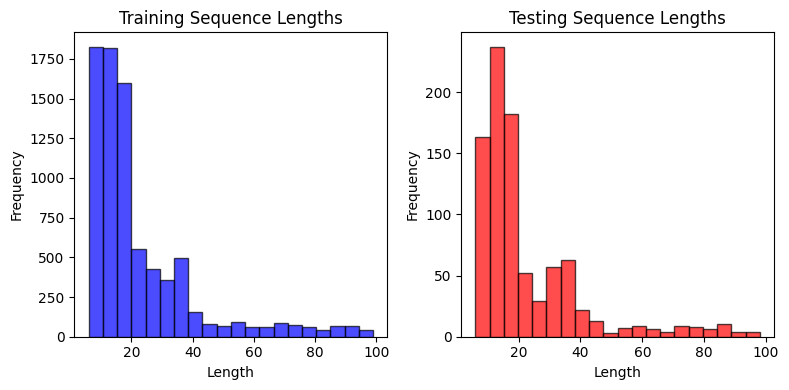

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.hist(train_df['seq'].apply(len), bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Training Sequence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(test_df['seq'].apply(len), bins=20, alpha=0.7, color='red', edgecolor='black')
plt.title('Testing Sequence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Model Architecture (transformer-based PLM)

### 1. Embedding Layer
* **Purpose**: Converts input token IDs into dense vector representations of a specified size.
* **Details**: Token IDs are mapped to vectors of size `hidden_size = 64`.

### 2. Transformer Layers

* **Purpose**: Processes sequences using self-attention mechanisms to capture contextual information and long-term dependencies.

* **Components**: The model includes 6 transformer layers, each containing:
  - **Multi-head Self-attention**: Allows the model to focus on different parts of the sequence simultaneously.
  - **Feed-Forward Network**: Processes attention outputs through linear transformations and non-linear activation (ReLU).
* **Why Transformers?**: Transformers model long-term dependencies more effectively than LSTMs and support more efficient parallelization.

### 3. Convolutional Layers
* **Components**:
  - **Projection Layer**: Projects transformer outputs into a format suitable for convolution.
  - **Conv1D Layer 1**: Applies a 1D convolution with a kernel size of 3 to capture local sequence patterns.
  - **Conv1D Layer 2**: Uses a kernel size of 1 to further downsample the sequence.

### 4. Attention Mechanism
* **Mechanism**: Enhances important features in the sequence by multiplying convolution outputs with learned weights, producing attention scores which are then normalized using softmax.

### 5. Fully Connected Network (FCN)
* **Components**:
  - **Linear Layer**: Reduces the dimensionality of the final sequence representations to match the number of output classes (binary classification in this case).


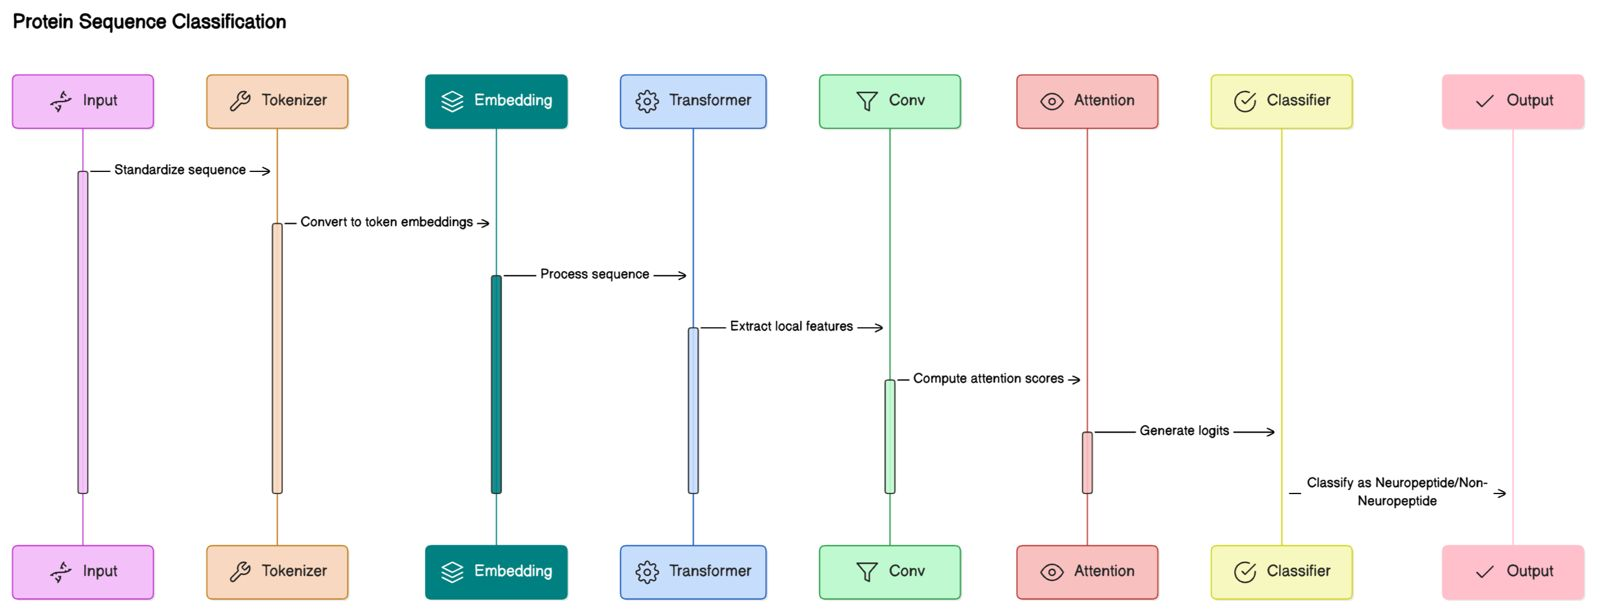

In [5]:
class NeuropeptideDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {'input_ids': self.inputs[idx], 'labels': self.labels[idx]}

In [6]:
hidden_size = 128
num_heads = 16
num_layers = 4

In [7]:
class DeepNeuroPred(nn.Module):
    def __init__(self, vocab_size, hidden_size=hidden_size, num_labels=2, num_heads=num_heads, num_layers=num_layers, projection_size=24):
        super(DeepNeuroPred, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads) for _ in range(num_layers)
        ])
        self.projection = nn.Linear(hidden_size, projection_size)
        self.cov_1 = nn.Conv1d(projection_size, projection_size, kernel_size=3, padding='same')
        self.cov_2 = nn.Conv1d(projection_size, int(projection_size/2), kernel_size=1, padding='same')
        self.W = nn.Parameter(torch.randn((num_heads, int(projection_size/2))))
        self.fcn = nn.Sequential(nn.Linear(int(projection_size/2) * num_heads, int(projection_size/2)),
                                 nn.ReLU(), nn.Linear(int(projection_size/2), num_labels))

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.transformer_layers:
            x = layer(x)

        # Projection and Convolution
        representations = self.projection(x)
        representations = rearrange(representations, 'b l d -> b d l')
        representation_cov = F.relu(self.cov_1(representations))
        representation_cov = F.relu(self.cov_2(representation_cov))
        representations = rearrange(representation_cov, 'b d l -> b l d')

        # Attention mechanism
        att = torch.einsum('bld,hd->blh', representations, self.W)
        att = F.softmax(att, dim=1)

        # Correct the dimensions for multiplication
        representations = representations.permute(0, 2, 1)
        att = att.permute(0, 2, 1)
        representations = torch.einsum('bcl,bhl->bch', representations, att)

        # Sum over the sequence length dimension
        representations = representations.view(representations.size(0), -1)
        return self.fcn(representations), att

In [8]:
model = nn.Sequential(
    *[nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads) for _ in range(num_layers)]
)
print(model)

Sequential(
  (0): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (1): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementw

In [9]:
# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of parameters: {total_params}")
print(f"Number of trainable parameters: {trainable_params}")

Total number of parameters: 2372096
Number of trainable parameters: 2372096


# Training and Evaluation Functions

In [10]:
def train_model(model, train_loader, val_loader, epochs, optimizer, scheduler, device):
    model.to(device)
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs, _ = model(inputs)
                loss = F.cross_entropy(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(all_labels, all_preds)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss / len(train_loader))
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        scheduler.step()

    # Plot the training and validation losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy over Epochs')
    plt.show()

In [11]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs, _ = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

    return all_preds, all_labels

# Load data into DataLoader

In [12]:
train_dataset = NeuropeptideDataset(train_texts, train_labels)
test_dataset = NeuropeptideDataset(test_texts, test_labels)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [13]:
# Initialize model, optimizer, and scheduler
vocab_size = tokenizer.vocab_size
model = DeepNeuroPred(vocab_size=vocab_size)  # Ensure `vocab_size` matches the tokenizer's
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

Epoch 1/10, Train Loss: 0.6033, Validation Loss: 0.4060, Validation Accuracy: 0.8271
Epoch 2/10, Train Loss: 0.3899, Validation Loss: 0.3591, Validation Accuracy: 0.8302
Epoch 3/10, Train Loss: 0.3602, Validation Loss: 0.3594, Validation Accuracy: 0.8352
Epoch 4/10, Train Loss: 0.3481, Validation Loss: 0.3306, Validation Accuracy: 0.8563
Epoch 5/10, Train Loss: 0.3404, Validation Loss: 0.3252, Validation Accuracy: 0.8545
Epoch 6/10, Train Loss: 0.3358, Validation Loss: 0.3188, Validation Accuracy: 0.8675
Epoch 7/10, Train Loss: 0.3269, Validation Loss: 0.3286, Validation Accuracy: 0.8619
Epoch 8/10, Train Loss: 0.3236, Validation Loss: 0.3206, Validation Accuracy: 0.8632
Epoch 9/10, Train Loss: 0.3217, Validation Loss: 0.3101, Validation Accuracy: 0.8675
Epoch 10/10, Train Loss: 0.3194, Validation Loss: 0.3119, Validation Accuracy: 0.8706


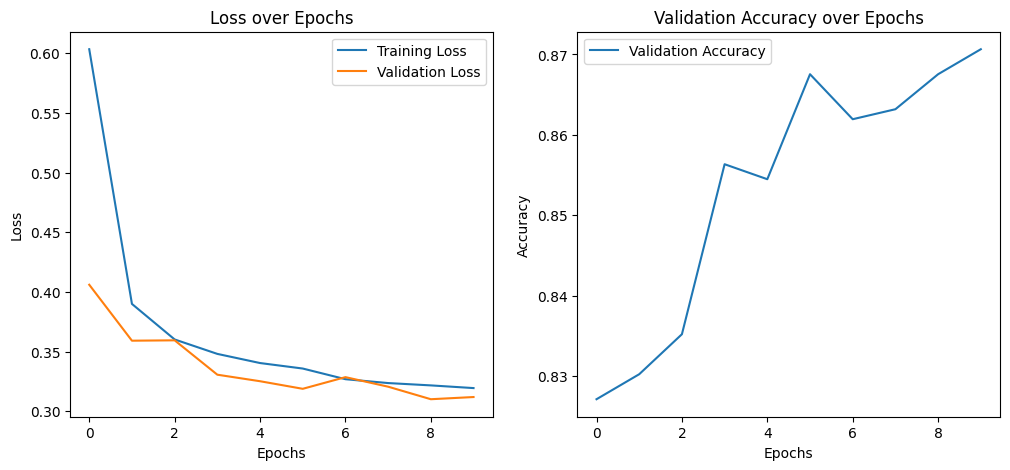

In [ ]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model(model, train_loader, val_loader, epochs=10, optimizer=optimizer, scheduler=scheduler, device=device)

In [26]:
from sklearn.metrics import classification_report

# Training and evaluation function with metrics table
def evaluate_and_report(model, train_loader, test_loader, device):
    model.eval()
    all_preds_train, all_labels_train = [], []
    all_preds_test, all_labels_test = [], []

    # Training data evaluation
    with torch.no_grad():
        for batch in train_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs, _ = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds_train.extend(preds.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())

    # Test data evaluation
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs, _ = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds_test.extend(preds.cpu().numpy())
            all_labels_test.extend(labels.cpu().numpy())

    # Generate metrics table
    train_report = classification_report(all_labels_train, all_preds_train, target_names=['Non-Neuropeptide', 'Neuropeptide'])
    test_report = classification_report(all_labels_test, all_preds_test, target_names=['Non-Neuropeptide', 'Neuropeptide'])

    print("Training Report:\n", train_report)
    print("Testing Report:\n", test_report)

evaluate_and_report(model, train_loader, test_loader, device)


Training Report:
                   precision    recall  f1-score   support

Non-Neuropeptide       0.90      0.87      0.88      3213
    Neuropeptide       0.87      0.90      0.89      3217

        accuracy                           0.88      6430
       macro avg       0.88      0.88      0.88      6430
    weighted avg       0.88      0.88      0.88      6430

Testing Report:
                   precision    recall  f1-score   support

Non-Neuropeptide       0.89      0.86      0.88       444
    Neuropeptide       0.87      0.90      0.88       444

        accuracy                           0.88       888
       macro avg       0.88      0.88      0.88       888
    weighted avg       0.88      0.88      0.88       888



Test Accuracy: 0.8795
F1 Score: 0.8795
Precision: 0.8801
Recall: 0.8795


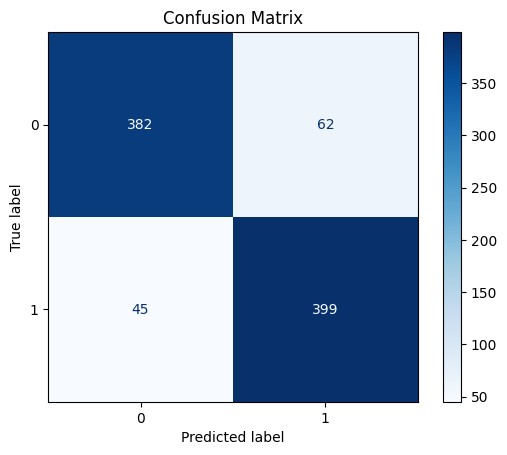

In [28]:
# Evaluate the model
all_preds, all_labels = evaluate_model(model, test_loader, device)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

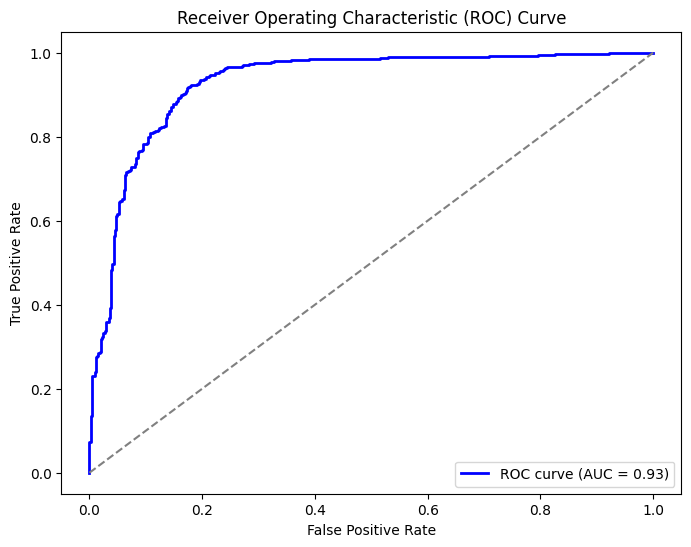

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, test_loader, device):
    model.eval()
    all_preds_prob = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs, _ = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1 (Neuropeptide)
            all_preds_prob.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage
plot_roc_curve(model, test_loader, device)


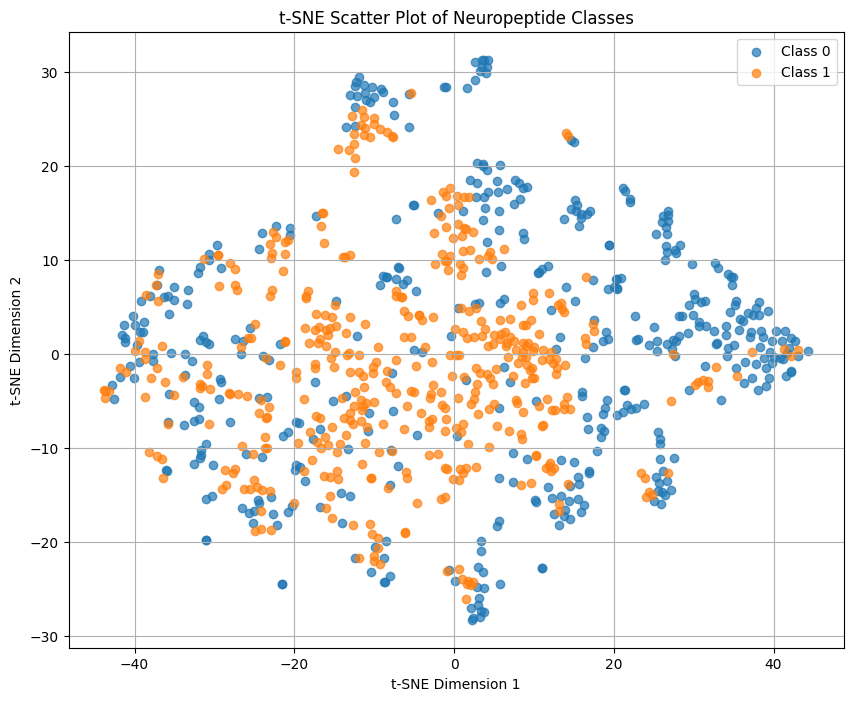

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_class_scatter(model, test_loader, device, title="Scatter Plot of Classes"):
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            labels.extend(batch['labels'].cpu().numpy())
            _, layer_outputs = model(inputs)

            # Calculate the mean across the sequence length to get a single embedding for each sample
            embeddings.append(layer_outputs.cpu().numpy().mean(axis=1))

    # Combine all embeddings and labels
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.array(labels)

    # Use t-SNE to reduce dimensions to 2D
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    # Scatter plot
    plt.figure(figsize=(10, 8))
    for class_label in np.unique(labels):
        idx = labels == class_label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"Class {class_label}", alpha=0.7)

    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_class_scatter(model, test_loader, device, title="t-SNE Scatter Plot of Neuropeptide Classes")

# Hyperparameter tuning

In [ ]:
def evaluate_model(model, data_loader, device, detailed_metrics=False, return_preds=False): # Add return_preds parameter
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs, _ = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)

    if detailed_metrics:
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)

        # Return all four values if both detailed_metrics and return_preds are True
        if return_preds:
            return accuracy, (precision, recall), all_labels, all_preds
        else:
            return accuracy, (precision, recall)  # Return tuple if detailed_metrics is True
    else:
        return accuracy  # Return only accuracy otherwise

Testing params: {'hidden_size': 64, 'learning_rate': 0.0001, 'num_heads': 4, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.5142, Validation Loss: 0.4160, Validation Accuracy: 0.8246
Epoch 2/10, Train Loss: 0.4148, Validation Loss: 0.3581, Validation Accuracy: 0.8340
Epoch 3/10, Train Loss: 0.3828, Validation Loss: 0.3315, Validation Accuracy: 0.8402
Epoch 4/10, Train Loss: 0.3654, Validation Loss: 0.3086, Validation Accuracy: 0.8539
Epoch 5/10, Train Loss: 0.3535, Validation Loss: 0.3121, Validation Accuracy: 0.8489
Epoch 6/10, Train Loss: 0.3461, Validation Loss: 0.3079, Validation Accuracy: 0.8831
Epoch 7/10, Train Loss: 0.3419, Validation Loss: 0.3052, Validation Accuracy: 0.8507
Epoch 8/10, Train Loss: 0.3384, Validation Loss: 0.2868, Validation Accuracy: 0.8731
Epoch 9/10, Train Loss: 0.3311, Validation Loss: 0.2916, Validation Accuracy: 0.8837
Epoch 10/10, Train Loss: 0.3272, Validation Loss: 0.2807, Validation Accuracy: 0.8744


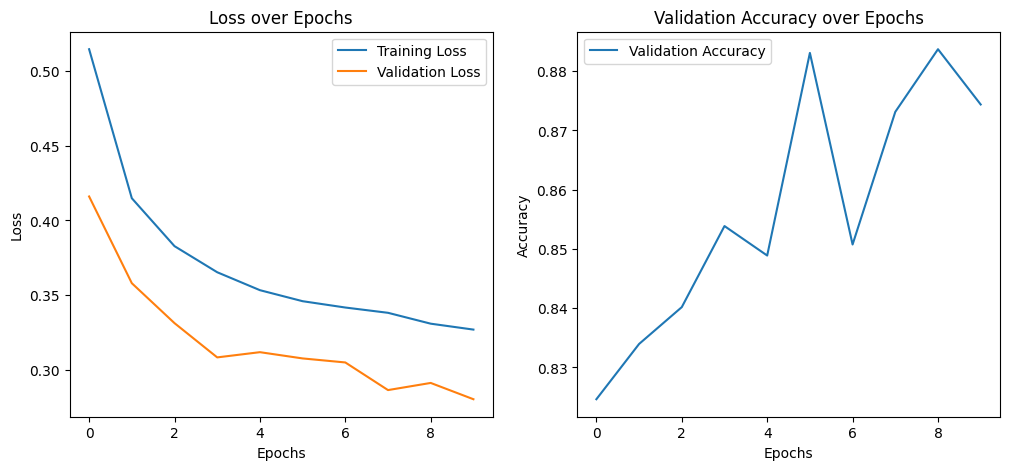

Testing params: {'hidden_size': 64, 'learning_rate': 0.0001, 'num_heads': 4, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.5839, Validation Loss: 0.4078, Validation Accuracy: 0.8259
Epoch 2/10, Train Loss: 0.4426, Validation Loss: 0.4520, Validation Accuracy: 0.8091
Epoch 3/10, Train Loss: 0.4444, Validation Loss: 0.3852, Validation Accuracy: 0.8402
Epoch 4/10, Train Loss: 0.4168, Validation Loss: 0.3510, Validation Accuracy: 0.8408
Epoch 5/10, Train Loss: 0.3821, Validation Loss: 0.3282, Validation Accuracy: 0.8451
Epoch 6/10, Train Loss: 0.3705, Validation Loss: 0.3209, Validation Accuracy: 0.8476
Epoch 7/10, Train Loss: 0.3591, Validation Loss: 0.3138, Validation Accuracy: 0.8507
Epoch 8/10, Train Loss: 0.3517, Validation Loss: 0.3144, Validation Accuracy: 0.8644
Epoch 9/10, Train Loss: 0.3438, Validation Loss: 0.3058, Validation Accuracy: 0.8520
Epoch 10/10, Train Loss: 0.3357, Validation Loss: 0.2962, Validation Accuracy: 0.8613


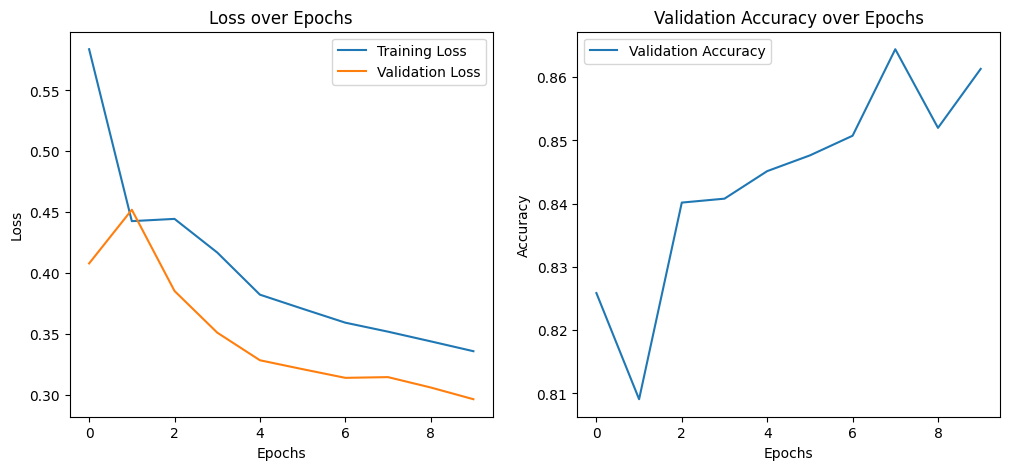

Testing params: {'hidden_size': 64, 'learning_rate': 0.0001, 'num_heads': 8, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.6423, Validation Loss: 0.4547, Validation Accuracy: 0.8240
Epoch 2/10, Train Loss: 0.3832, Validation Loss: 0.3178, Validation Accuracy: 0.8588
Epoch 3/10, Train Loss: 0.3568, Validation Loss: 0.3339, Validation Accuracy: 0.8476
Epoch 4/10, Train Loss: 0.3458, Validation Loss: 0.3037, Validation Accuracy: 0.8526
Epoch 5/10, Train Loss: 0.3384, Validation Loss: 0.2921, Validation Accuracy: 0.8657
Epoch 6/10, Train Loss: 0.3341, Validation Loss: 0.3027, Validation Accuracy: 0.8520
Epoch 7/10, Train Loss: 0.3228, Validation Loss: 0.2755, Validation Accuracy: 0.8713
Epoch 8/10, Train Loss: 0.3176, Validation Loss: 0.2717, Validation Accuracy: 0.8725
Epoch 9/10, Train Loss: 0.3102, Validation Loss: 0.2700, Validation Accuracy: 0.8744
Epoch 10/10, Train Loss: 0.3068, Validation Loss: 0.2769, Validation Accuracy: 0.8632


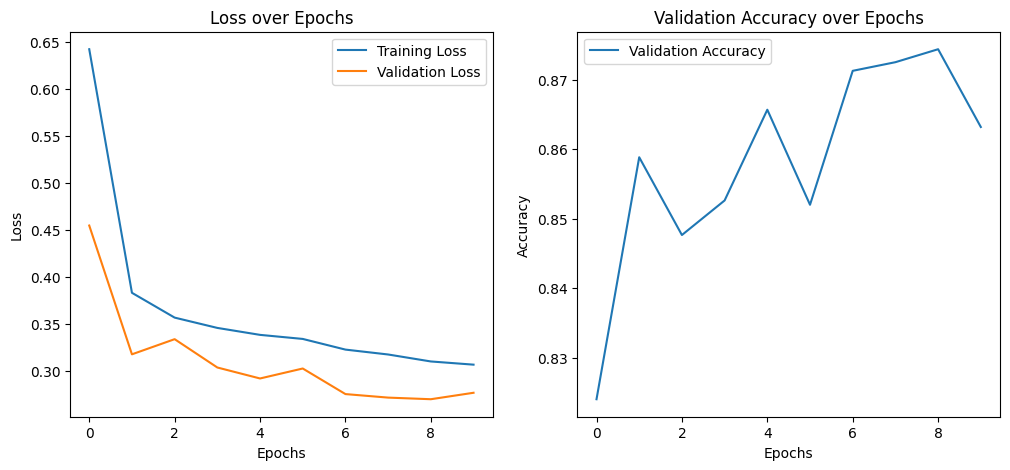

Testing params: {'hidden_size': 64, 'learning_rate': 0.0001, 'num_heads': 8, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.5502, Validation Loss: 0.4079, Validation Accuracy: 0.8246
Epoch 2/10, Train Loss: 0.4314, Validation Loss: 0.4072, Validation Accuracy: 0.8246
Epoch 3/10, Train Loss: 0.4271, Validation Loss: 0.3953, Validation Accuracy: 0.8246
Epoch 4/10, Train Loss: 0.4196, Validation Loss: 0.3907, Validation Accuracy: 0.8265
Epoch 5/10, Train Loss: 0.4165, Validation Loss: 0.3848, Validation Accuracy: 0.8246
Epoch 6/10, Train Loss: 0.4178, Validation Loss: 0.3853, Validation Accuracy: 0.8240
Epoch 7/10, Train Loss: 0.4108, Validation Loss: 0.3579, Validation Accuracy: 0.8377
Epoch 8/10, Train Loss: 0.3850, Validation Loss: 0.3457, Validation Accuracy: 0.8451
Epoch 9/10, Train Loss: 0.3767, Validation Loss: 0.3380, Validation Accuracy: 0.8439
Epoch 10/10, Train Loss: 0.3712, Validation Loss: 0.3333, Validation Accuracy: 0.8364


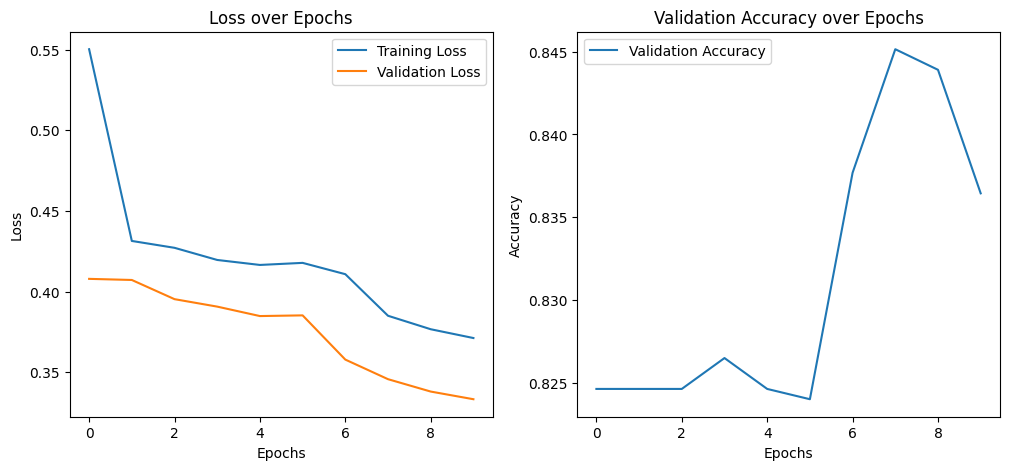

Testing params: {'hidden_size': 64, 'learning_rate': 0.0001, 'num_heads': 16, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.5109, Validation Loss: 0.3344, Validation Accuracy: 0.8414
Epoch 2/10, Train Loss: 0.3664, Validation Loss: 0.3218, Validation Accuracy: 0.8402
Epoch 3/10, Train Loss: 0.3513, Validation Loss: 0.3025, Validation Accuracy: 0.8632
Epoch 4/10, Train Loss: 0.3382, Validation Loss: 0.2890, Validation Accuracy: 0.8638
Epoch 5/10, Train Loss: 0.3267, Validation Loss: 0.2846, Validation Accuracy: 0.8694
Epoch 6/10, Train Loss: 0.3166, Validation Loss: 0.2906, Validation Accuracy: 0.8563
Epoch 7/10, Train Loss: 0.3133, Validation Loss: 0.2828, Validation Accuracy: 0.8769
Epoch 8/10, Train Loss: 0.3065, Validation Loss: 0.2726, Validation Accuracy: 0.8688
Epoch 9/10, Train Loss: 0.3050, Validation Loss: 0.2698, Validation Accuracy: 0.8825
Epoch 10/10, Train Loss: 0.3008, Validation Loss: 0.2714, Validation Accuracy: 0.8850


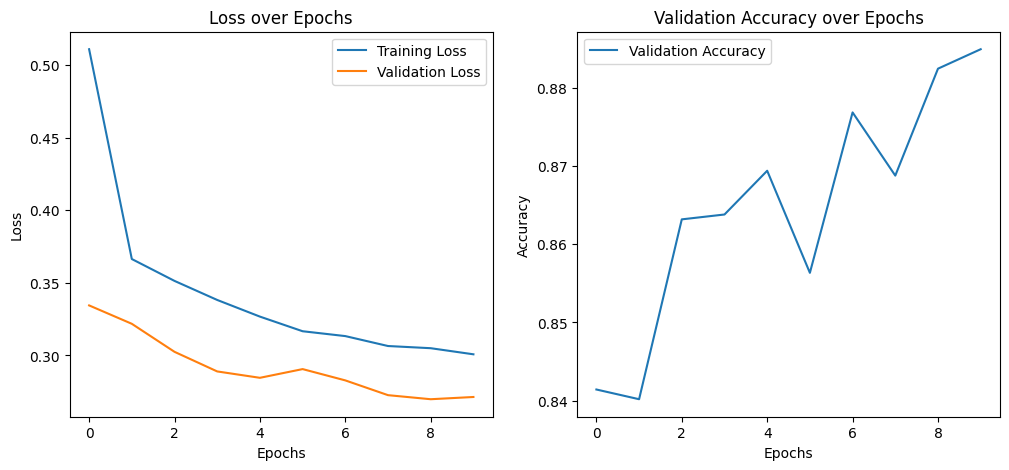

Testing params: {'hidden_size': 64, 'learning_rate': 0.0001, 'num_heads': 16, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.5418, Validation Loss: 0.3997, Validation Accuracy: 0.8396
Epoch 2/10, Train Loss: 0.4415, Validation Loss: 0.4064, Validation Accuracy: 0.8327
Epoch 3/10, Train Loss: 0.4158, Validation Loss: 0.3821, Validation Accuracy: 0.8265
Epoch 4/10, Train Loss: 0.3882, Validation Loss: 0.3323, Validation Accuracy: 0.8427
Epoch 5/10, Train Loss: 0.3659, Validation Loss: 0.3248, Validation Accuracy: 0.8520
Epoch 6/10, Train Loss: 0.3580, Validation Loss: 0.3231, Validation Accuracy: 0.8563
Epoch 7/10, Train Loss: 0.3512, Validation Loss: 0.3067, Validation Accuracy: 0.8557
Epoch 8/10, Train Loss: 0.3406, Validation Loss: 0.2937, Validation Accuracy: 0.8750
Epoch 9/10, Train Loss: 0.3356, Validation Loss: 0.2892, Validation Accuracy: 0.8719
Epoch 10/10, Train Loss: 0.3277, Validation Loss: 0.2846, Validation Accuracy: 0.8713


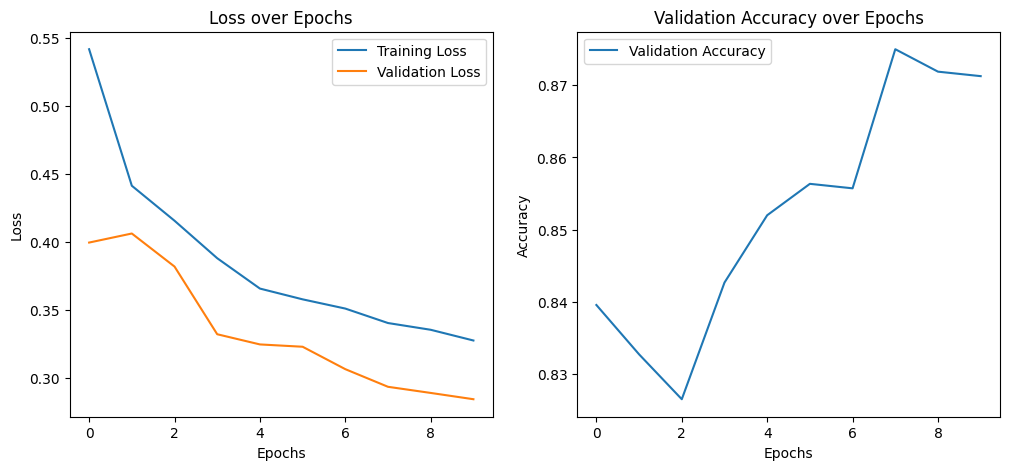

Testing params: {'hidden_size': 64, 'learning_rate': 1e-05, 'num_heads': 4, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.6907, Validation Loss: 0.6840, Validation Accuracy: 0.4820
Epoch 2/10, Train Loss: 0.6677, Validation Loss: 0.6478, Validation Accuracy: 0.8234
Epoch 3/10, Train Loss: 0.6322, Validation Loss: 0.6068, Validation Accuracy: 0.8265
Epoch 4/10, Train Loss: 0.5911, Validation Loss: 0.5637, Validation Accuracy: 0.8252
Epoch 5/10, Train Loss: 0.5547, Validation Loss: 0.5281, Validation Accuracy: 0.8184
Epoch 6/10, Train Loss: 0.5223, Validation Loss: 0.4935, Validation Accuracy: 0.8134
Epoch 7/10, Train Loss: 0.4926, Validation Loss: 0.4648, Validation Accuracy: 0.8184
Epoch 8/10, Train Loss: 0.4696, Validation Loss: 0.4393, Validation Accuracy: 0.8203
Epoch 9/10, Train Loss: 0.4467, Validation Loss: 0.4154, Validation Accuracy: 0.8234
Epoch 10/10, Train Loss: 0.4315, Validation Loss: 0.4004, Validation Accuracy: 0.8240


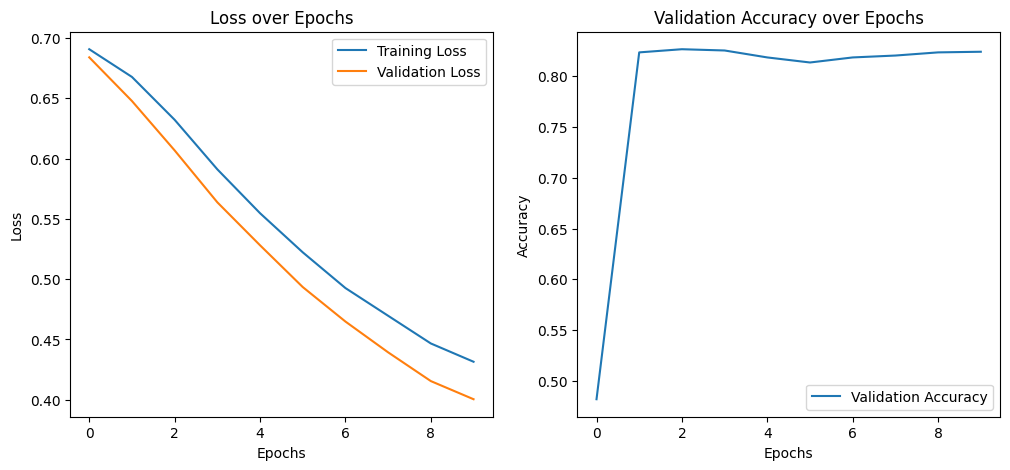

Testing params: {'hidden_size': 64, 'learning_rate': 1e-05, 'num_heads': 4, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.6940, Validation Loss: 0.6945, Validation Accuracy: 0.4813
Epoch 2/10, Train Loss: 0.6894, Validation Loss: 0.6886, Validation Accuracy: 0.4813
Epoch 3/10, Train Loss: 0.6830, Validation Loss: 0.6792, Validation Accuracy: 0.5087
Epoch 4/10, Train Loss: 0.6716, Validation Loss: 0.6632, Validation Accuracy: 0.6244
Epoch 5/10, Train Loss: 0.6547, Validation Loss: 0.6422, Validation Accuracy: 0.6866
Epoch 6/10, Train Loss: 0.6330, Validation Loss: 0.6179, Validation Accuracy: 0.7519
Epoch 7/10, Train Loss: 0.6081, Validation Loss: 0.5900, Validation Accuracy: 0.7718
Epoch 8/10, Train Loss: 0.5839, Validation Loss: 0.5644, Validation Accuracy: 0.7612
Epoch 9/10, Train Loss: 0.5566, Validation Loss: 0.5344, Validation Accuracy: 0.8184
Epoch 10/10, Train Loss: 0.5331, Validation Loss: 0.5053, Validation Accuracy: 0.8165


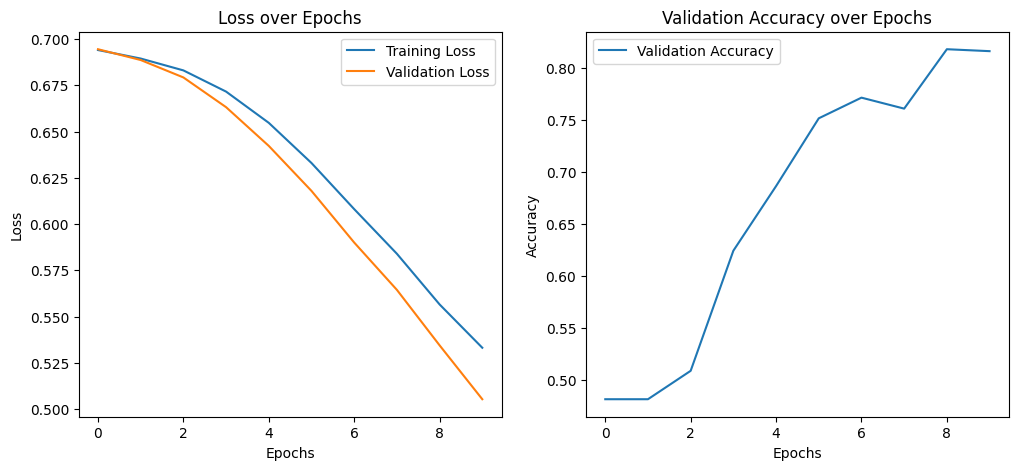

Testing params: {'hidden_size': 64, 'learning_rate': 1e-05, 'num_heads': 8, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.6890, Validation Loss: 0.6636, Validation Accuracy: 0.6437
Epoch 2/10, Train Loss: 0.6248, Validation Loss: 0.5680, Validation Accuracy: 0.8420
Epoch 3/10, Train Loss: 0.5424, Validation Loss: 0.4910, Validation Accuracy: 0.8427
Epoch 4/10, Train Loss: 0.4821, Validation Loss: 0.4346, Validation Accuracy: 0.8408
Epoch 5/10, Train Loss: 0.4393, Validation Loss: 0.3999, Validation Accuracy: 0.8420
Epoch 6/10, Train Loss: 0.4150, Validation Loss: 0.3794, Validation Accuracy: 0.8408
Epoch 7/10, Train Loss: 0.3993, Validation Loss: 0.3635, Validation Accuracy: 0.8507
Epoch 8/10, Train Loss: 0.3872, Validation Loss: 0.3547, Validation Accuracy: 0.8507
Epoch 9/10, Train Loss: 0.3816, Validation Loss: 0.3473, Validation Accuracy: 0.8507
Epoch 10/10, Train Loss: 0.3757, Validation Loss: 0.3426, Validation Accuracy: 0.8514


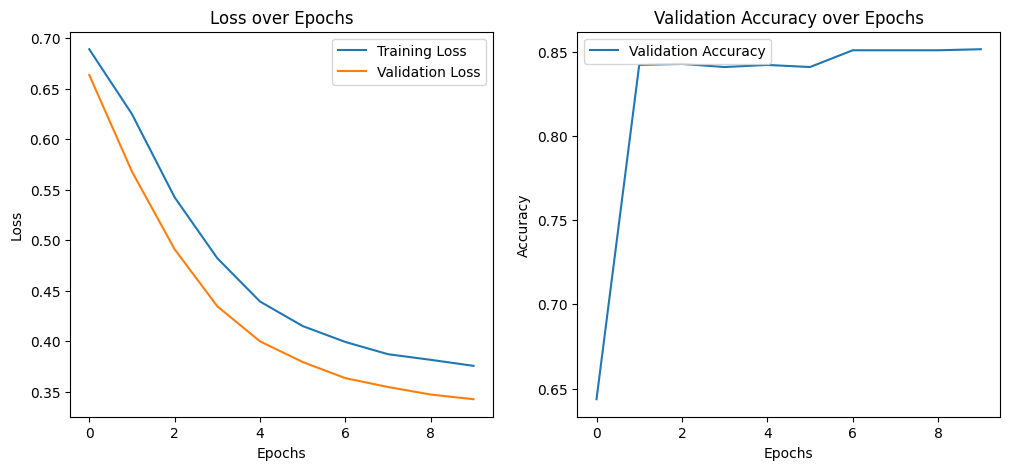

Testing params: {'hidden_size': 64, 'learning_rate': 1e-05, 'num_heads': 8, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.6894, Validation Loss: 0.6834, Validation Accuracy: 0.5056
Epoch 2/10, Train Loss: 0.6695, Validation Loss: 0.6447, Validation Accuracy: 0.6480
Epoch 3/10, Train Loss: 0.6107, Validation Loss: 0.5581, Validation Accuracy: 0.8414
Epoch 4/10, Train Loss: 0.5254, Validation Loss: 0.4746, Validation Accuracy: 0.8420
Epoch 5/10, Train Loss: 0.4627, Validation Loss: 0.4188, Validation Accuracy: 0.8408
Epoch 6/10, Train Loss: 0.4259, Validation Loss: 0.3886, Validation Accuracy: 0.8458
Epoch 7/10, Train Loss: 0.4060, Validation Loss: 0.3698, Validation Accuracy: 0.8539
Epoch 8/10, Train Loss: 0.3943, Validation Loss: 0.3570, Validation Accuracy: 0.8483
Epoch 9/10, Train Loss: 0.3835, Validation Loss: 0.3520, Validation Accuracy: 0.8507
Epoch 10/10, Train Loss: 0.3800, Validation Loss: 0.3466, Validation Accuracy: 0.8476


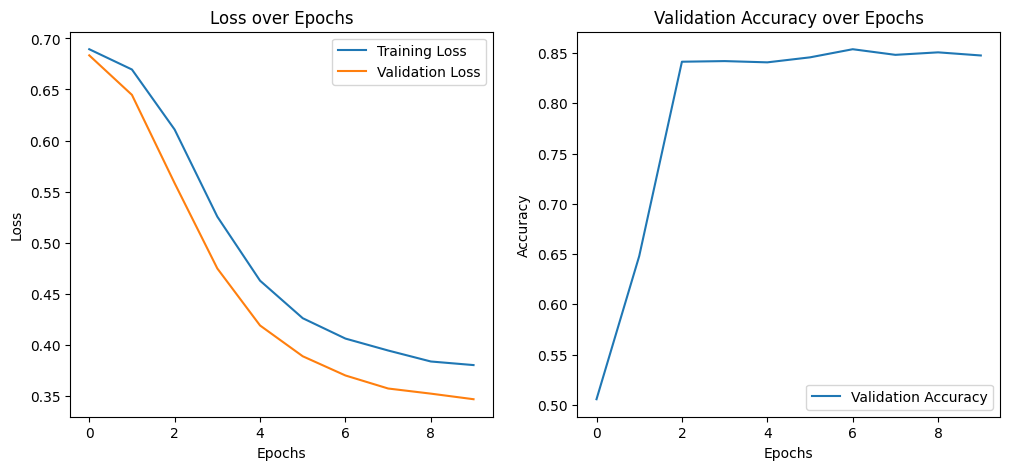

Testing params: {'hidden_size': 64, 'learning_rate': 1e-05, 'num_heads': 16, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.6888, Validation Loss: 0.6808, Validation Accuracy: 0.5124
Epoch 2/10, Train Loss: 0.6538, Validation Loss: 0.5822, Validation Accuracy: 0.8358
Epoch 3/10, Train Loss: 0.5181, Validation Loss: 0.4443, Validation Accuracy: 0.8271
Epoch 4/10, Train Loss: 0.4371, Validation Loss: 0.3913, Validation Accuracy: 0.8277
Epoch 5/10, Train Loss: 0.4075, Validation Loss: 0.3698, Validation Accuracy: 0.8371
Epoch 6/10, Train Loss: 0.3904, Validation Loss: 0.3536, Validation Accuracy: 0.8408
Epoch 7/10, Train Loss: 0.3834, Validation Loss: 0.3483, Validation Accuracy: 0.8408
Epoch 8/10, Train Loss: 0.3758, Validation Loss: 0.3437, Validation Accuracy: 0.8445
Epoch 9/10, Train Loss: 0.3739, Validation Loss: 0.3382, Validation Accuracy: 0.8433
Epoch 10/10, Train Loss: 0.3685, Validation Loss: 0.3355, Validation Accuracy: 0.8451


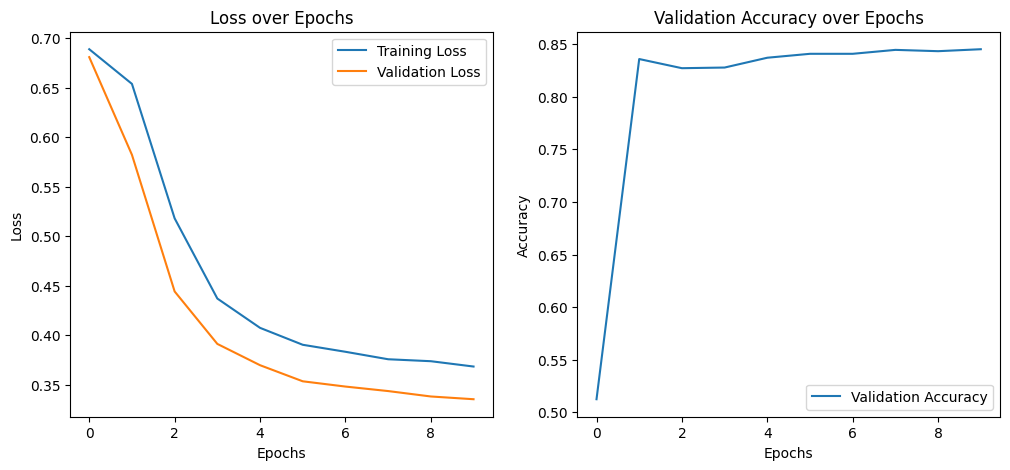

Testing params: {'hidden_size': 64, 'learning_rate': 1e-05, 'num_heads': 16, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.6909, Validation Loss: 0.6835, Validation Accuracy: 0.6430
Epoch 2/10, Train Loss: 0.6486, Validation Loss: 0.5720, Validation Accuracy: 0.8302
Epoch 3/10, Train Loss: 0.5123, Validation Loss: 0.4391, Validation Accuracy: 0.8228
Epoch 4/10, Train Loss: 0.4352, Validation Loss: 0.3931, Validation Accuracy: 0.8252
Epoch 5/10, Train Loss: 0.4086, Validation Loss: 0.3704, Validation Accuracy: 0.8333
Epoch 6/10, Train Loss: 0.3928, Validation Loss: 0.3579, Validation Accuracy: 0.8358
Epoch 7/10, Train Loss: 0.3877, Validation Loss: 0.3507, Validation Accuracy: 0.8402
Epoch 8/10, Train Loss: 0.3785, Validation Loss: 0.3441, Validation Accuracy: 0.8501
Epoch 9/10, Train Loss: 0.3727, Validation Loss: 0.3392, Validation Accuracy: 0.8501
Epoch 10/10, Train Loss: 0.3707, Validation Loss: 0.3366, Validation Accuracy: 0.8501


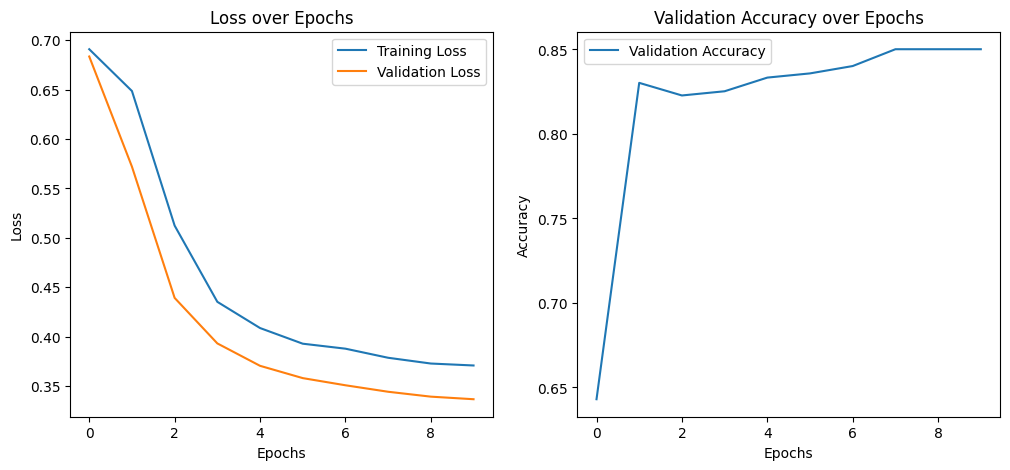

Testing params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_heads': 4, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.4790, Validation Loss: 0.3666, Validation Accuracy: 0.8259
Epoch 2/10, Train Loss: 0.3912, Validation Loss: 0.3440, Validation Accuracy: 0.8302
Epoch 3/10, Train Loss: 0.3755, Validation Loss: 0.3499, Validation Accuracy: 0.8315
Epoch 4/10, Train Loss: 0.3662, Validation Loss: 0.3230, Validation Accuracy: 0.8507
Epoch 5/10, Train Loss: 0.3567, Validation Loss: 0.3261, Validation Accuracy: 0.8383
Epoch 6/10, Train Loss: 0.3548, Validation Loss: 0.3164, Validation Accuracy: 0.8427
Epoch 7/10, Train Loss: 0.3499, Validation Loss: 0.3103, Validation Accuracy: 0.8464
Epoch 8/10, Train Loss: 0.3441, Validation Loss: 0.3083, Validation Accuracy: 0.8526
Epoch 9/10, Train Loss: 0.3444, Validation Loss: 0.3079, Validation Accuracy: 0.8445
Epoch 10/10, Train Loss: 0.3394, Validation Loss: 0.2968, Validation Accuracy: 0.8557


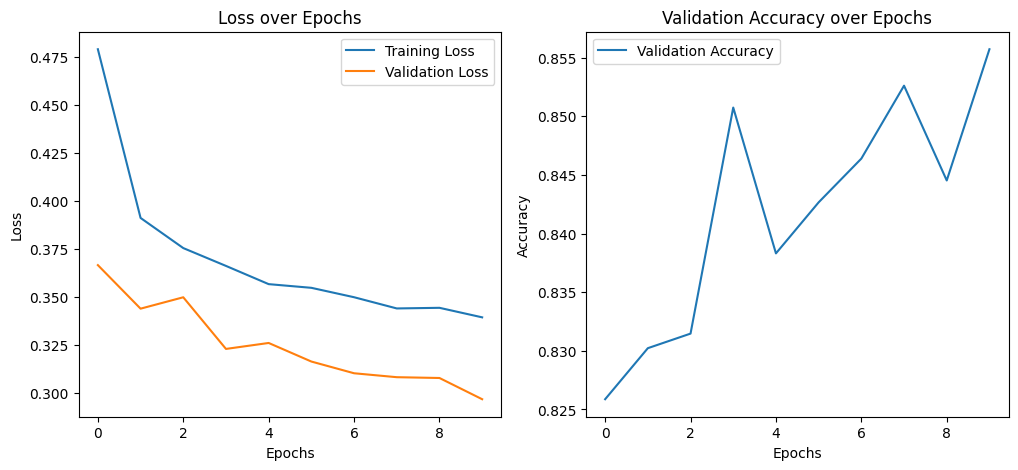

Testing params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_heads': 4, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.6941, Validation Loss: 0.6932, Validation Accuracy: 0.4813
Epoch 2/10, Train Loss: 0.6405, Validation Loss: 0.4119, Validation Accuracy: 0.8246
Epoch 3/10, Train Loss: 0.4509, Validation Loss: 0.4093, Validation Accuracy: 0.8209
Epoch 4/10, Train Loss: 0.4313, Validation Loss: 0.4063, Validation Accuracy: 0.8246
Epoch 5/10, Train Loss: 0.4277, Validation Loss: 0.4065, Validation Accuracy: 0.8246
Epoch 6/10, Train Loss: 0.4309, Validation Loss: 0.4068, Validation Accuracy: 0.8246
Epoch 7/10, Train Loss: 0.4303, Validation Loss: 0.4080, Validation Accuracy: 0.8246
Epoch 8/10, Train Loss: 0.4301, Validation Loss: 0.4041, Validation Accuracy: 0.8240
Epoch 9/10, Train Loss: 0.4299, Validation Loss: 0.4051, Validation Accuracy: 0.8246
Epoch 10/10, Train Loss: 0.4299, Validation Loss: 0.4049, Validation Accuracy: 0.8246


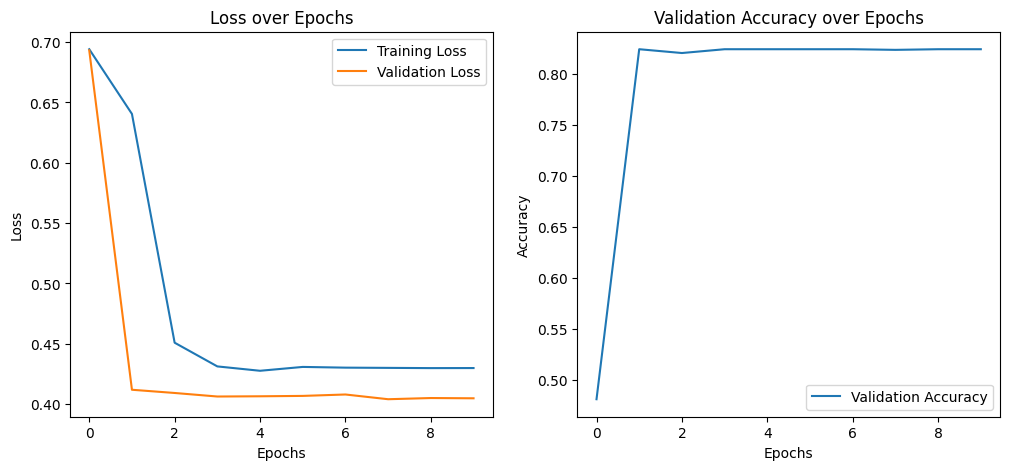

Testing params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_heads': 8, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.6264, Validation Loss: 0.5058, Validation Accuracy: 0.7662
Epoch 2/10, Train Loss: 0.4081, Validation Loss: 0.3486, Validation Accuracy: 0.8389
Epoch 3/10, Train Loss: 0.3714, Validation Loss: 0.3210, Validation Accuracy: 0.8514
Epoch 4/10, Train Loss: 0.3546, Validation Loss: 0.3084, Validation Accuracy: 0.8675
Epoch 5/10, Train Loss: 0.3393, Validation Loss: 0.3041, Validation Accuracy: 0.8563
Epoch 6/10, Train Loss: 0.3292, Validation Loss: 0.2981, Validation Accuracy: 0.8657
Epoch 7/10, Train Loss: 0.3242, Validation Loss: 0.2928, Validation Accuracy: 0.8719
Epoch 8/10, Train Loss: 0.3188, Validation Loss: 0.2958, Validation Accuracy: 0.8675
Epoch 9/10, Train Loss: 0.3135, Validation Loss: 0.2901, Validation Accuracy: 0.8744
Epoch 10/10, Train Loss: 0.3099, Validation Loss: 0.2872, Validation Accuracy: 0.8675


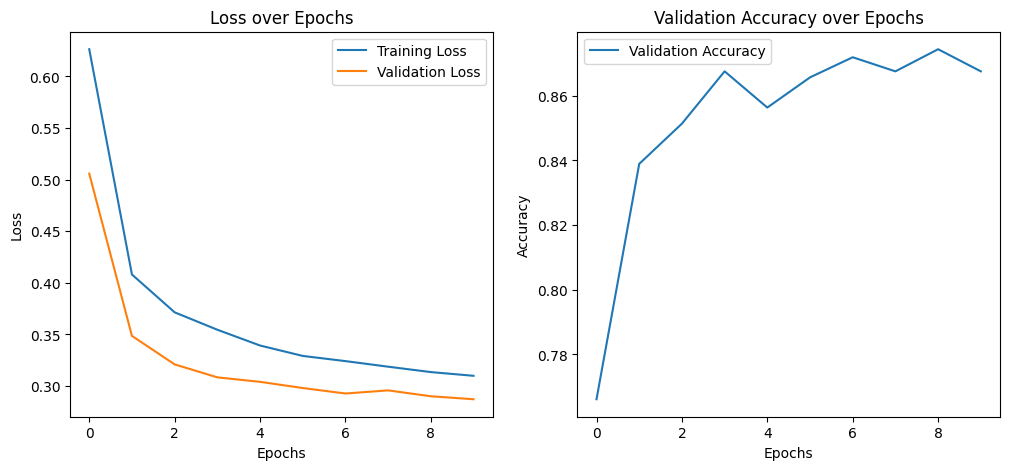

Testing params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_heads': 8, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.5300, Validation Loss: 0.4068, Validation Accuracy: 0.8047
Epoch 2/10, Train Loss: 0.4279, Validation Loss: 0.3762, Validation Accuracy: 0.8178
Epoch 3/10, Train Loss: 0.4034, Validation Loss: 0.3648, Validation Accuracy: 0.8221
Epoch 4/10, Train Loss: 0.3999, Validation Loss: 0.3475, Validation Accuracy: 0.8402
Epoch 5/10, Train Loss: 0.3839, Validation Loss: 0.3415, Validation Accuracy: 0.8433
Epoch 6/10, Train Loss: 0.3794, Validation Loss: 0.3355, Validation Accuracy: 0.8476
Epoch 7/10, Train Loss: 0.3671, Validation Loss: 0.3193, Validation Accuracy: 0.8570
Epoch 8/10, Train Loss: 0.3607, Validation Loss: 0.3330, Validation Accuracy: 0.8451
Epoch 9/10, Train Loss: 0.3555, Validation Loss: 0.3059, Validation Accuracy: 0.8682
Epoch 10/10, Train Loss: 0.3415, Validation Loss: 0.2982, Validation Accuracy: 0.8675


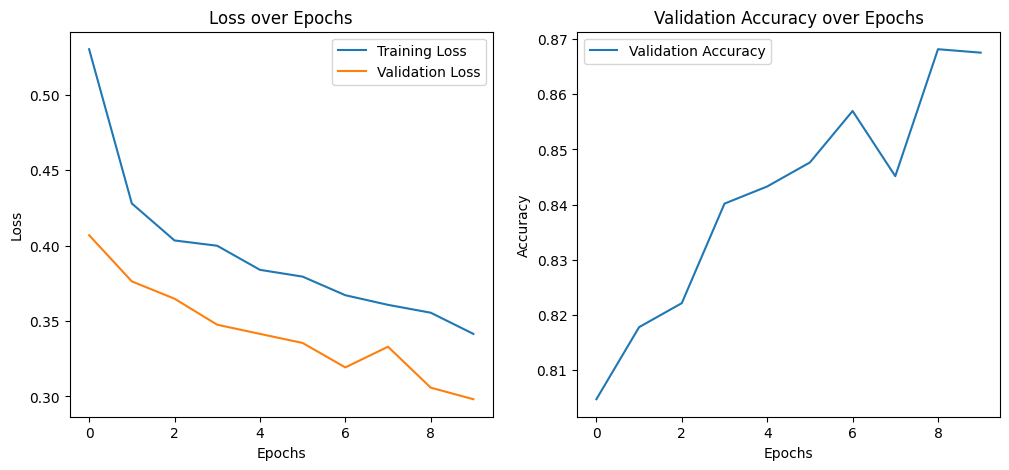

Testing params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_heads': 16, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.4903, Validation Loss: 0.3331, Validation Accuracy: 0.8532
Epoch 2/10, Train Loss: 0.3653, Validation Loss: 0.3124, Validation Accuracy: 0.8576
Epoch 3/10, Train Loss: 0.3490, Validation Loss: 0.3094, Validation Accuracy: 0.8451
Epoch 4/10, Train Loss: 0.3349, Validation Loss: 0.2895, Validation Accuracy: 0.8762
Epoch 5/10, Train Loss: 0.3256, Validation Loss: 0.2789, Validation Accuracy: 0.8806
Epoch 6/10, Train Loss: 0.3142, Validation Loss: 0.2804, Validation Accuracy: 0.8781
Epoch 7/10, Train Loss: 0.3060, Validation Loss: 0.2667, Validation Accuracy: 0.8794
Epoch 8/10, Train Loss: 0.2961, Validation Loss: 0.2672, Validation Accuracy: 0.8856
Epoch 9/10, Train Loss: 0.2934, Validation Loss: 0.2543, Validation Accuracy: 0.8874
Epoch 10/10, Train Loss: 0.2864, Validation Loss: 0.2608, Validation Accuracy: 0.8874


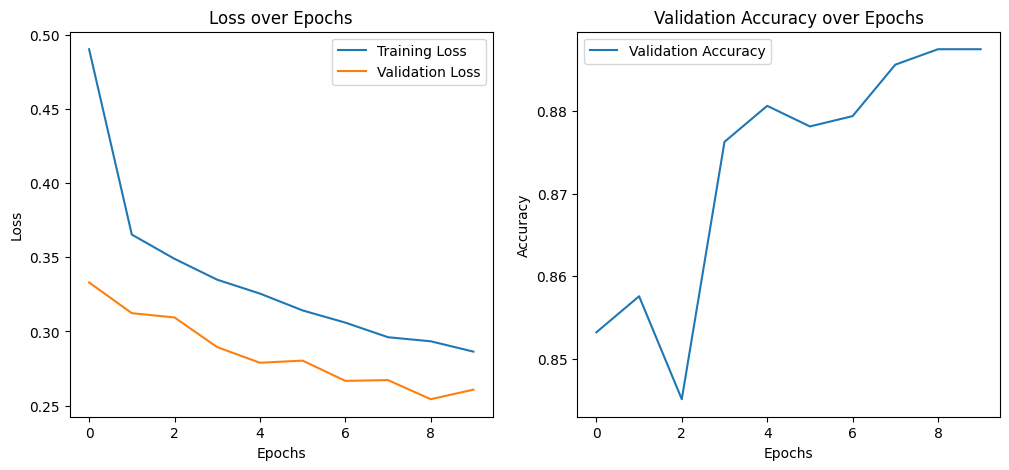

Testing params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_heads': 16, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.5335, Validation Loss: 0.3949, Validation Accuracy: 0.8265
Epoch 2/10, Train Loss: 0.4184, Validation Loss: 0.3878, Validation Accuracy: 0.8290
Epoch 3/10, Train Loss: 0.4094, Validation Loss: 0.3730, Validation Accuracy: 0.8290
Epoch 4/10, Train Loss: 0.3929, Validation Loss: 0.3448, Validation Accuracy: 0.8451
Epoch 5/10, Train Loss: 0.3765, Validation Loss: 0.3437, Validation Accuracy: 0.8433
Epoch 6/10, Train Loss: 0.3718, Validation Loss: 0.3344, Validation Accuracy: 0.8439
Epoch 7/10, Train Loss: 0.3682, Validation Loss: 0.3489, Validation Accuracy: 0.8427
Epoch 8/10, Train Loss: 0.3803, Validation Loss: 0.3571, Validation Accuracy: 0.8352
Epoch 9/10, Train Loss: 0.3825, Validation Loss: 0.3517, Validation Accuracy: 0.8383
Epoch 10/10, Train Loss: 0.3792, Validation Loss: 0.3496, Validation Accuracy: 0.8383


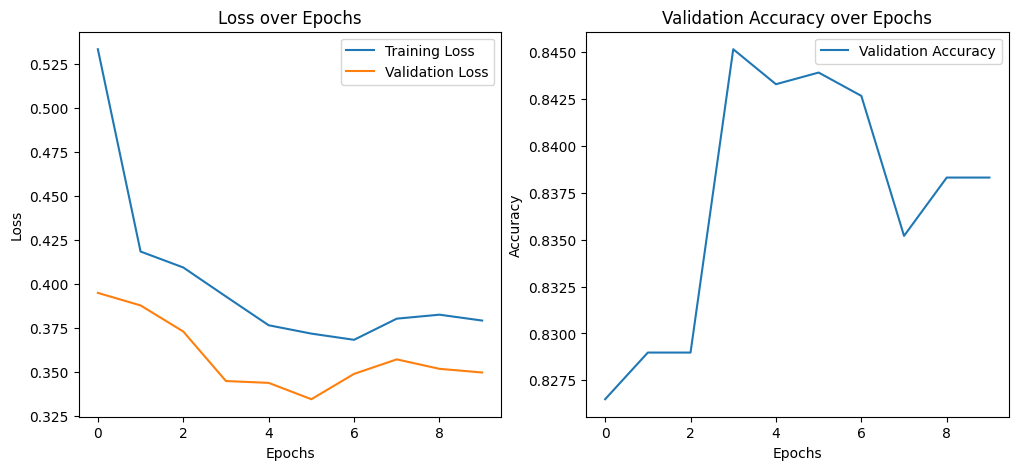

Testing params: {'hidden_size': 128, 'learning_rate': 1e-05, 'num_heads': 4, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.7023, Validation Loss: 0.6993, Validation Accuracy: 0.4813
Epoch 2/10, Train Loss: 0.6569, Validation Loss: 0.5985, Validation Accuracy: 0.8246
Epoch 3/10, Train Loss: 0.5637, Validation Loss: 0.5072, Validation Accuracy: 0.8252
Epoch 4/10, Train Loss: 0.4889, Validation Loss: 0.4444, Validation Accuracy: 0.8221
Epoch 5/10, Train Loss: 0.4492, Validation Loss: 0.4179, Validation Accuracy: 0.8252
Epoch 6/10, Train Loss: 0.4312, Validation Loss: 0.4067, Validation Accuracy: 0.8228
Epoch 7/10, Train Loss: 0.4207, Validation Loss: 0.3918, Validation Accuracy: 0.8315
Epoch 8/10, Train Loss: 0.4138, Validation Loss: 0.3846, Validation Accuracy: 0.8315
Epoch 9/10, Train Loss: 0.4076, Validation Loss: 0.3808, Validation Accuracy: 0.8340
Epoch 10/10, Train Loss: 0.4048, Validation Loss: 0.3797, Validation Accuracy: 0.8327


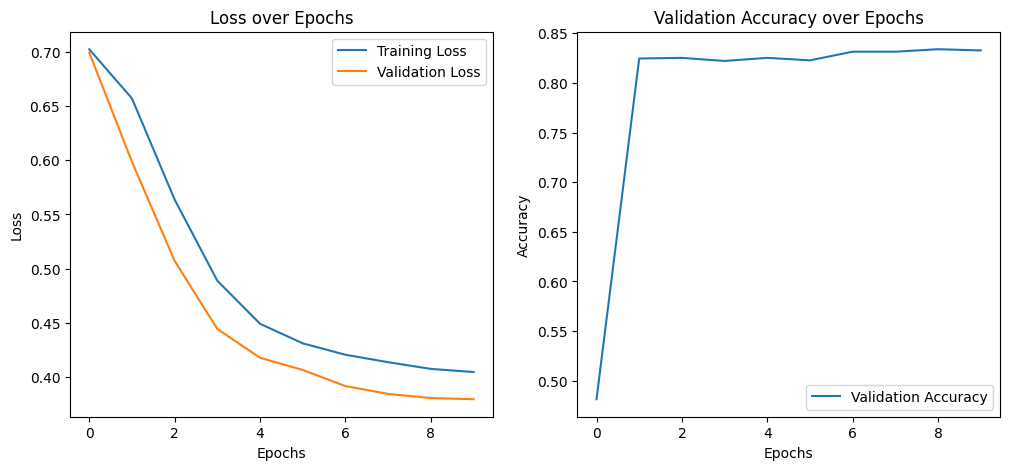

Testing params: {'hidden_size': 128, 'learning_rate': 1e-05, 'num_heads': 4, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.6903, Validation Loss: 0.6085, Validation Accuracy: 0.5187
Epoch 2/10, Train Loss: 0.6107, Validation Loss: 0.5705, Validation Accuracy: 0.5187
Epoch 3/10, Train Loss: 0.5909, Validation Loss: 0.5584, Validation Accuracy: 0.5187
Epoch 4/10, Train Loss: 0.5833, Validation Loss: 0.5526, Validation Accuracy: 0.5187
Epoch 5/10, Train Loss: 0.5790, Validation Loss: 0.5486, Validation Accuracy: 0.5187
Epoch 6/10, Train Loss: 0.5757, Validation Loss: 0.5449, Validation Accuracy: 0.5187
Epoch 7/10, Train Loss: 0.5734, Validation Loss: 0.5431, Validation Accuracy: 0.5187
Epoch 8/10, Train Loss: 0.5714, Validation Loss: 0.5416, Validation Accuracy: 0.5187
Epoch 9/10, Train Loss: 0.5694, Validation Loss: 0.5395, Validation Accuracy: 0.5187
Epoch 10/10, Train Loss: 0.5680, Validation Loss: 0.5379, Validation Accuracy: 0.5187


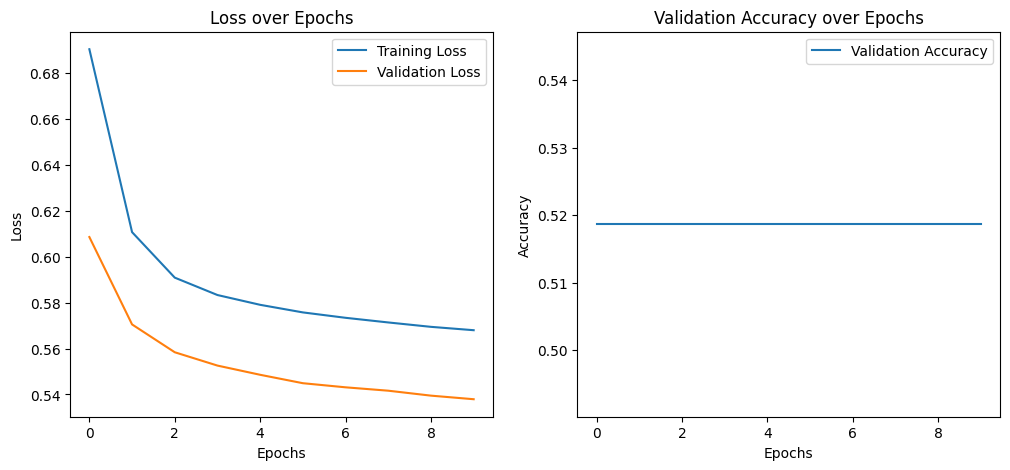

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing params: {'hidden_size': 128, 'learning_rate': 1e-05, 'num_heads': 8, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.6852, Validation Loss: 0.6658, Validation Accuracy: 0.6835
Epoch 2/10, Train Loss: 0.6578, Validation Loss: 0.6417, Validation Accuracy: 0.7083
Epoch 3/10, Train Loss: 0.6324, Validation Loss: 0.6194, Validation Accuracy: 0.7108
Epoch 4/10, Train Loss: 0.6027, Validation Loss: 0.5720, Validation Accuracy: 0.7463
Epoch 5/10, Train Loss: 0.5190, Validation Loss: 0.4475, Validation Accuracy: 0.8215
Epoch 6/10, Train Loss: 0.4323, Validation Loss: 0.3924, Validation Accuracy: 0.8371
Epoch 7/10, Train Loss: 0.3957, Validation Loss: 0.3671, Validation Accuracy: 0.8352
Epoch 8/10, Train Loss: 0.3774, Validation Loss: 0.3495, Validation Accuracy: 0.8439
Epoch 9/10, Train Loss: 0.3637, Validation Loss: 0.3382, Validation Accuracy: 0.8420
Epoch 10/10, Train Loss: 0.3549, Validation Loss: 0.3313, Validation Accuracy: 0.8483


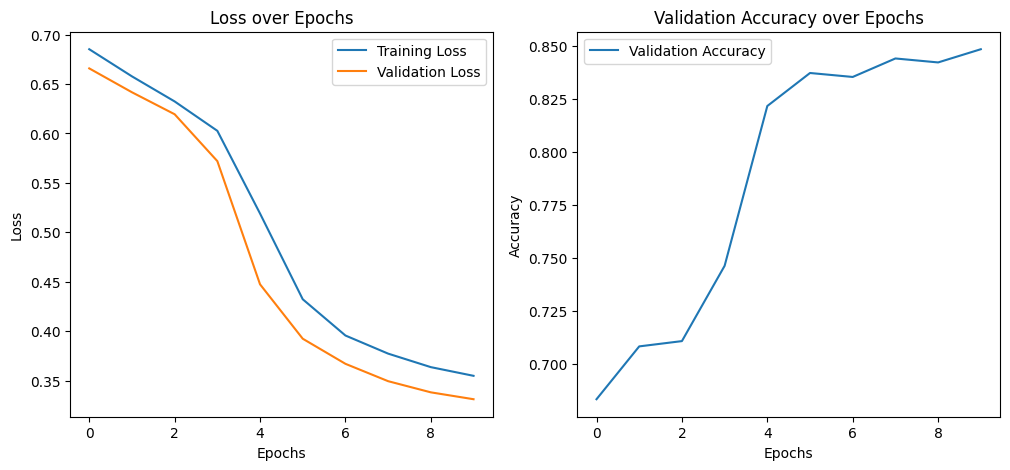

Testing params: {'hidden_size': 128, 'learning_rate': 1e-05, 'num_heads': 8, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.6827, Validation Loss: 0.6503, Validation Accuracy: 0.7848
Epoch 2/10, Train Loss: 0.6077, Validation Loss: 0.5493, Validation Accuracy: 0.8308
Epoch 3/10, Train Loss: 0.5010, Validation Loss: 0.4301, Validation Accuracy: 0.8402
Epoch 4/10, Train Loss: 0.4319, Validation Loss: 0.3927, Validation Accuracy: 0.8383
Epoch 5/10, Train Loss: 0.4064, Validation Loss: 0.3673, Validation Accuracy: 0.8483
Epoch 6/10, Train Loss: 0.3920, Validation Loss: 0.3664, Validation Accuracy: 0.8433
Epoch 7/10, Train Loss: 0.3832, Validation Loss: 0.3572, Validation Accuracy: 0.8507
Epoch 8/10, Train Loss: 0.3800, Validation Loss: 0.3479, Validation Accuracy: 0.8514
Epoch 9/10, Train Loss: 0.3741, Validation Loss: 0.3471, Validation Accuracy: 0.8483
Epoch 10/10, Train Loss: 0.3723, Validation Loss: 0.3410, Validation Accuracy: 0.8563


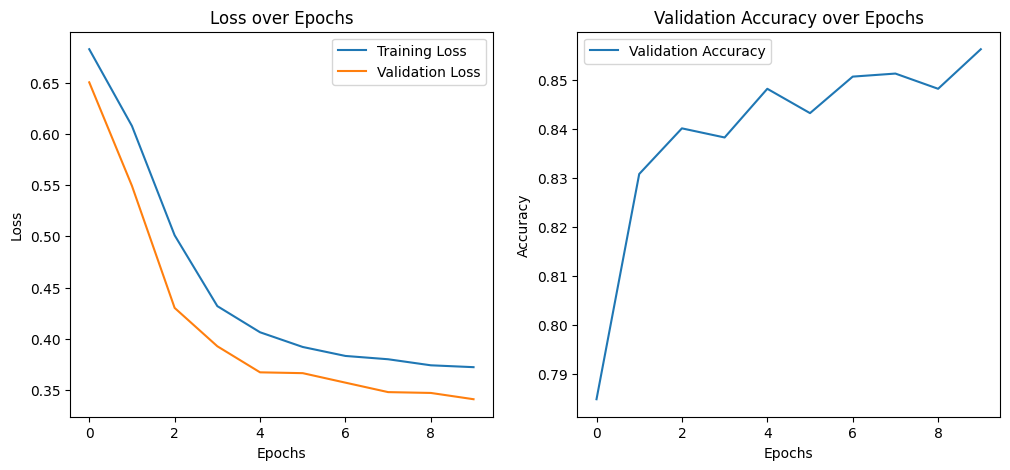

Testing params: {'hidden_size': 128, 'learning_rate': 1e-05, 'num_heads': 16, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.6980, Validation Loss: 0.7029, Validation Accuracy: 0.4813
Epoch 2/10, Train Loss: 0.6978, Validation Loss: 0.7026, Validation Accuracy: 0.4813
Epoch 3/10, Train Loss: 0.6975, Validation Loss: 0.7006, Validation Accuracy: 0.4813
Epoch 4/10, Train Loss: 0.6904, Validation Loss: 0.6839, Validation Accuracy: 0.4813
Epoch 5/10, Train Loss: 0.6693, Validation Loss: 0.6547, Validation Accuracy: 0.8066
Epoch 6/10, Train Loss: 0.6380, Validation Loss: 0.6195, Validation Accuracy: 0.8246
Epoch 7/10, Train Loss: 0.6047, Validation Loss: 0.5820, Validation Accuracy: 0.8240
Epoch 8/10, Train Loss: 0.5686, Validation Loss: 0.5443, Validation Accuracy: 0.8277
Epoch 9/10, Train Loss: 0.5380, Validation Loss: 0.5132, Validation Accuracy: 0.8290
Epoch 10/10, Train Loss: 0.5135, Validation Loss: 0.4887, Validation Accuracy: 0.8271


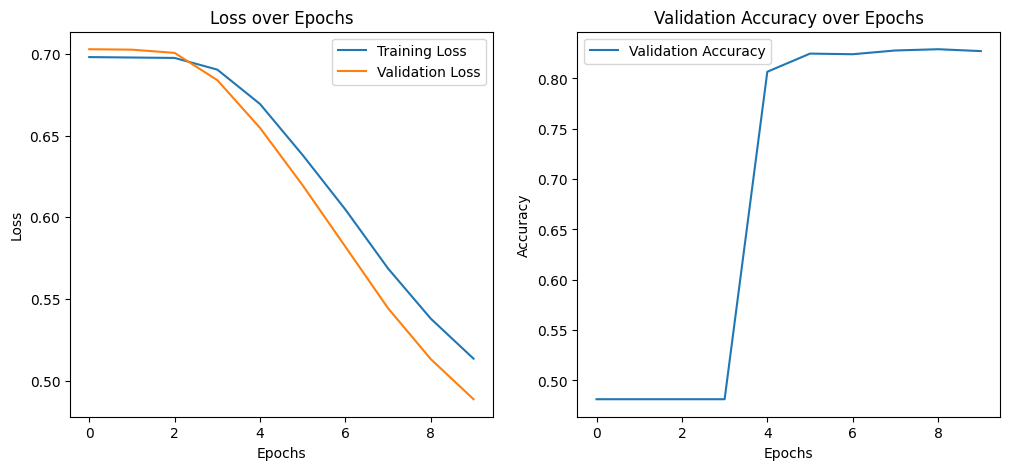

Testing params: {'hidden_size': 128, 'learning_rate': 1e-05, 'num_heads': 16, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.6241, Validation Loss: 0.5369, Validation Accuracy: 0.8240
Epoch 2/10, Train Loss: 0.4957, Validation Loss: 0.4387, Validation Accuracy: 0.8246
Epoch 3/10, Train Loss: 0.4301, Validation Loss: 0.3916, Validation Accuracy: 0.8228
Epoch 4/10, Train Loss: 0.3994, Validation Loss: 0.3623, Validation Accuracy: 0.8321
Epoch 5/10, Train Loss: 0.3797, Validation Loss: 0.3419, Validation Accuracy: 0.8371
Epoch 6/10, Train Loss: 0.3669, Validation Loss: 0.3285, Validation Accuracy: 0.8414
Epoch 7/10, Train Loss: 0.3567, Validation Loss: 0.3179, Validation Accuracy: 0.8470
Epoch 8/10, Train Loss: 0.3488, Validation Loss: 0.3090, Validation Accuracy: 0.8563
Epoch 9/10, Train Loss: 0.3421, Validation Loss: 0.3047, Validation Accuracy: 0.8613
Epoch 10/10, Train Loss: 0.3380, Validation Loss: 0.3011, Validation Accuracy: 0.8607


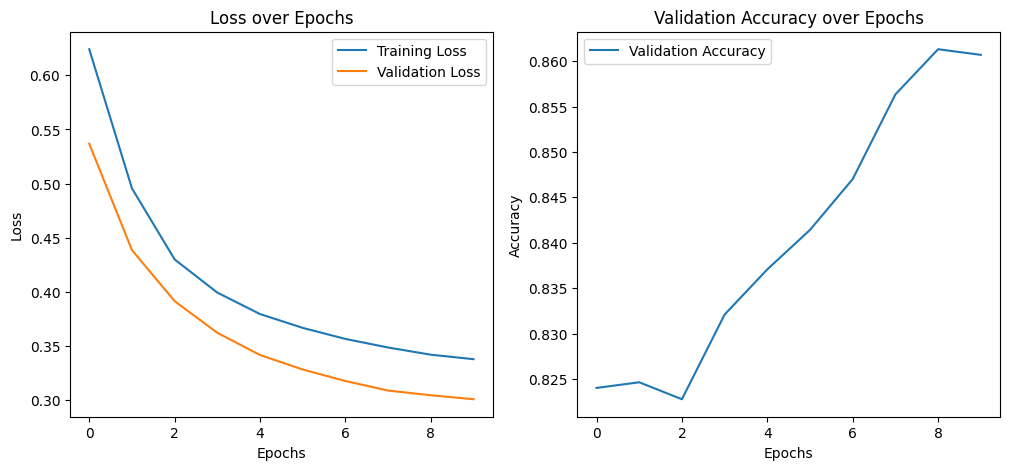

Testing params: {'hidden_size': 256, 'learning_rate': 0.0001, 'num_heads': 4, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.5539, Validation Loss: 0.4533, Validation Accuracy: 0.8016
Epoch 2/10, Train Loss: 0.3919, Validation Loss: 0.3516, Validation Accuracy: 0.8346
Epoch 3/10, Train Loss: 0.3493, Validation Loss: 0.3221, Validation Accuracy: 0.8545
Epoch 4/10, Train Loss: 0.3303, Validation Loss: 0.3022, Validation Accuracy: 0.8706
Epoch 5/10, Train Loss: 0.3197, Validation Loss: 0.2781, Validation Accuracy: 0.8756
Epoch 6/10, Train Loss: 0.3121, Validation Loss: 0.2736, Validation Accuracy: 0.8775
Epoch 7/10, Train Loss: 0.3115, Validation Loss: 0.2625, Validation Accuracy: 0.8862
Epoch 8/10, Train Loss: 0.3015, Validation Loss: 0.2654, Validation Accuracy: 0.8825
Epoch 9/10, Train Loss: 0.2970, Validation Loss: 0.2660, Validation Accuracy: 0.8775
Epoch 10/10, Train Loss: 0.2993, Validation Loss: 0.2691, Validation Accuracy: 0.8856


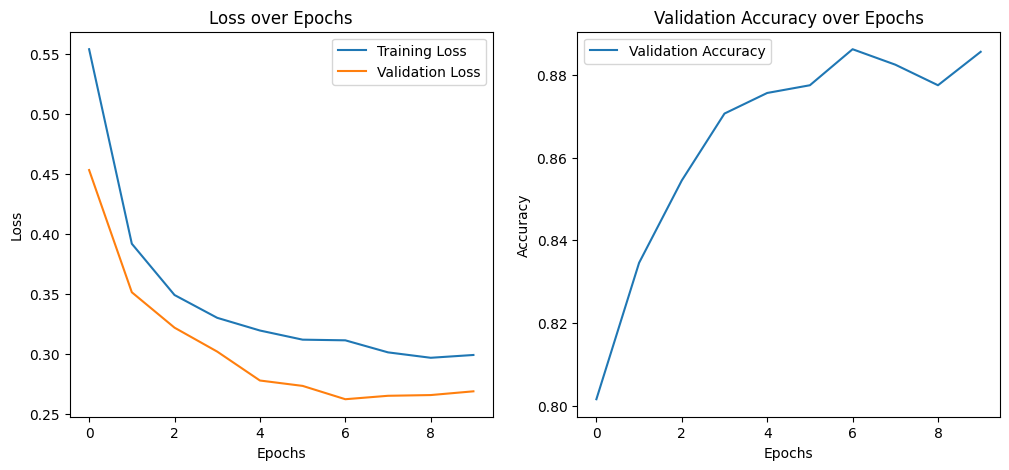

Testing params: {'hidden_size': 256, 'learning_rate': 0.0001, 'num_heads': 4, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.5011, Validation Loss: 0.4533, Validation Accuracy: 0.8109
Epoch 2/10, Train Loss: 0.4475, Validation Loss: 0.4285, Validation Accuracy: 0.8035
Epoch 3/10, Train Loss: 0.4511, Validation Loss: 0.6571, Validation Accuracy: 0.6412
Epoch 4/10, Train Loss: 0.5732, Validation Loss: 0.4461, Validation Accuracy: 0.8215
Epoch 5/10, Train Loss: 0.4575, Validation Loss: 0.4229, Validation Accuracy: 0.8234
Epoch 6/10, Train Loss: 0.4434, Validation Loss: 0.4213, Validation Accuracy: 0.8252
Epoch 7/10, Train Loss: 0.4428, Validation Loss: 0.4208, Validation Accuracy: 0.8234
Epoch 8/10, Train Loss: 0.4382, Validation Loss: 0.4387, Validation Accuracy: 0.8147
Epoch 9/10, Train Loss: 0.4451, Validation Loss: 0.4203, Validation Accuracy: 0.8228
Epoch 10/10, Train Loss: 0.4367, Validation Loss: 0.4172, Validation Accuracy: 0.8252


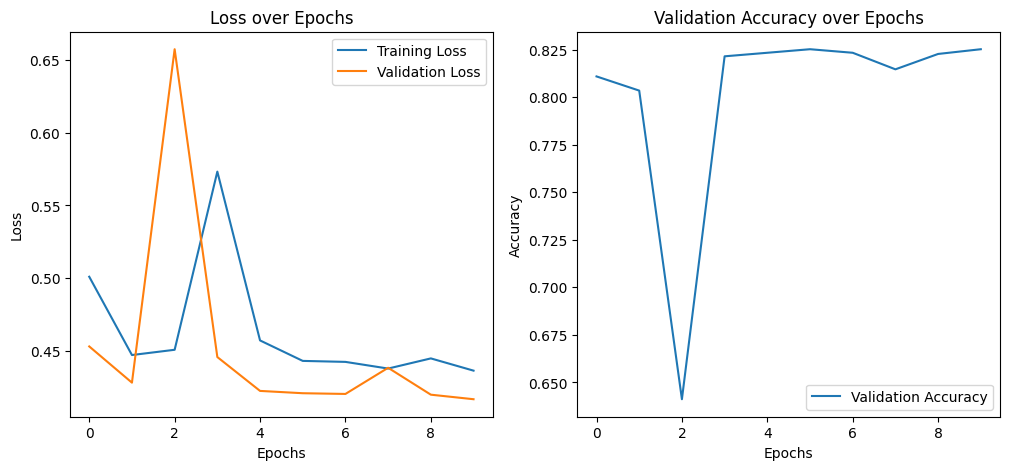

Testing params: {'hidden_size': 256, 'learning_rate': 0.0001, 'num_heads': 8, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.5023, Validation Loss: 0.4053, Validation Accuracy: 0.8246
Epoch 2/10, Train Loss: 0.4221, Validation Loss: 0.3882, Validation Accuracy: 0.8321
Epoch 3/10, Train Loss: 0.4083, Validation Loss: 0.3630, Validation Accuracy: 0.8296
Epoch 4/10, Train Loss: 0.3959, Validation Loss: 0.3613, Validation Accuracy: 0.8321
Epoch 5/10, Train Loss: 0.3879, Validation Loss: 0.3512, Validation Accuracy: 0.8377
Epoch 6/10, Train Loss: 0.3775, Validation Loss: 0.3534, Validation Accuracy: 0.8346
Epoch 7/10, Train Loss: 0.3662, Validation Loss: 0.3284, Validation Accuracy: 0.8439
Epoch 8/10, Train Loss: 0.3600, Validation Loss: 0.3172, Validation Accuracy: 0.8483
Epoch 9/10, Train Loss: 0.3497, Validation Loss: 0.3087, Validation Accuracy: 0.8520
Epoch 10/10, Train Loss: 0.3457, Validation Loss: 0.3040, Validation Accuracy: 0.8539


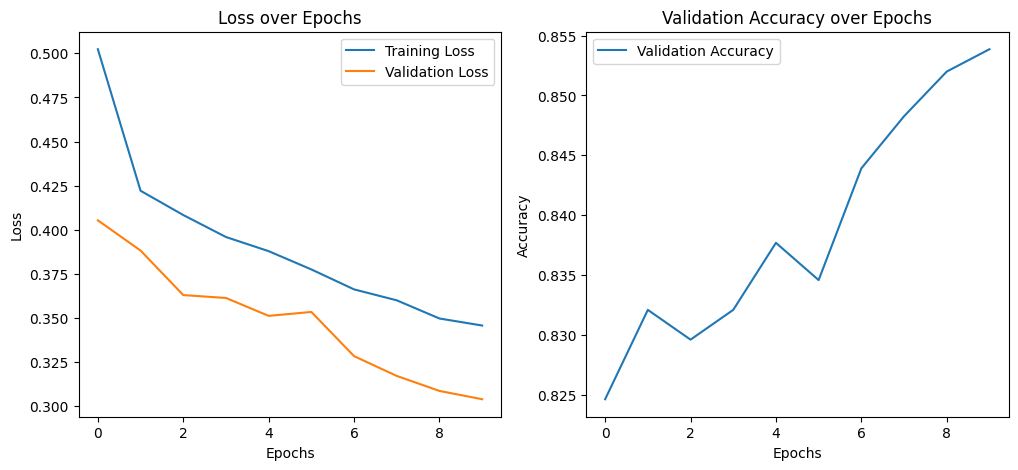

Testing params: {'hidden_size': 256, 'learning_rate': 0.0001, 'num_heads': 8, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.6095, Validation Loss: 0.6060, Validation Accuracy: 0.6853
Epoch 2/10, Train Loss: 0.6628, Validation Loss: 0.6661, Validation Accuracy: 0.6001
Epoch 3/10, Train Loss: 0.6666, Validation Loss: 0.6583, Validation Accuracy: 0.6101
Epoch 4/10, Train Loss: 0.6538, Validation Loss: 0.6145, Validation Accuracy: 0.6505
Epoch 5/10, Train Loss: 0.6187, Validation Loss: 0.6700, Validation Accuracy: 0.5429
Epoch 6/10, Train Loss: 0.6612, Validation Loss: 0.6840, Validation Accuracy: 0.5852
Epoch 7/10, Train Loss: 0.6630, Validation Loss: 0.6582, Validation Accuracy: 0.6095
Epoch 8/10, Train Loss: 0.6767, Validation Loss: 0.6925, Validation Accuracy: 0.5211
Epoch 9/10, Train Loss: 0.6914, Validation Loss: 0.6941, Validation Accuracy: 0.4813
Epoch 10/10, Train Loss: 0.6935, Validation Loss: 0.6937, Validation Accuracy: 0.4813


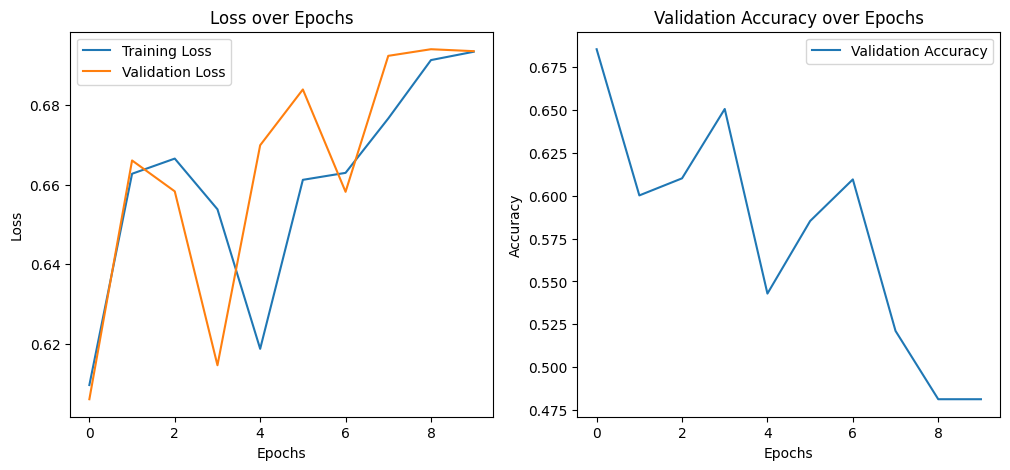

Testing params: {'hidden_size': 256, 'learning_rate': 0.0001, 'num_heads': 16, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.5173, Validation Loss: 0.4014, Validation Accuracy: 0.8246
Epoch 2/10, Train Loss: 0.4294, Validation Loss: 0.3828, Validation Accuracy: 0.8246
Epoch 3/10, Train Loss: 0.4173, Validation Loss: 0.3841, Validation Accuracy: 0.8246
Epoch 4/10, Train Loss: 0.4138, Validation Loss: 0.3868, Validation Accuracy: 0.8252
Epoch 5/10, Train Loss: 0.4113, Validation Loss: 0.3757, Validation Accuracy: 0.8377
Epoch 6/10, Train Loss: 0.4032, Validation Loss: 0.3703, Validation Accuracy: 0.8246
Epoch 7/10, Train Loss: 0.3910, Validation Loss: 0.3544, Validation Accuracy: 0.8246
Epoch 8/10, Train Loss: 0.3787, Validation Loss: 0.3439, Validation Accuracy: 0.8396
Epoch 9/10, Train Loss: 0.3687, Validation Loss: 0.3387, Validation Accuracy: 0.8507
Epoch 10/10, Train Loss: 0.3588, Validation Loss: 0.3292, Validation Accuracy: 0.8439


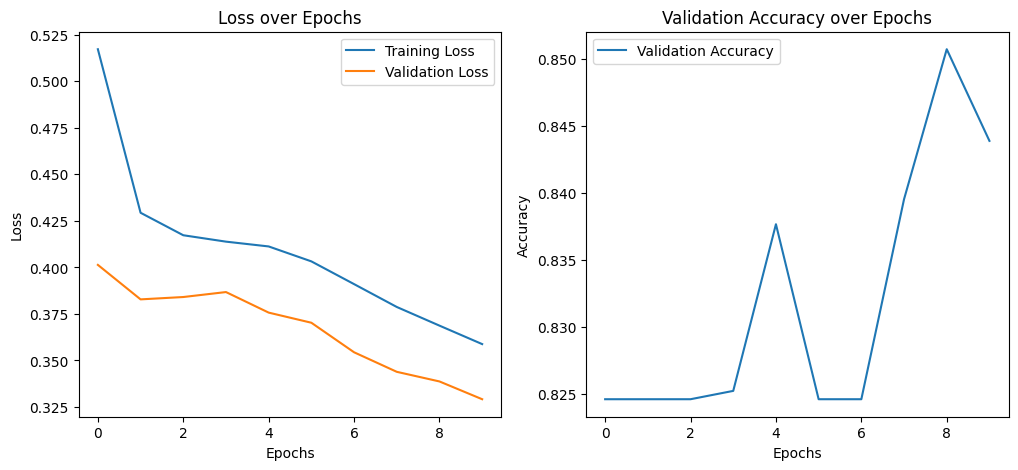

Testing params: {'hidden_size': 256, 'learning_rate': 0.0001, 'num_heads': 16, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.4824, Validation Loss: 0.4070, Validation Accuracy: 0.8246
Epoch 2/10, Train Loss: 0.4367, Validation Loss: 0.4008, Validation Accuracy: 0.8246
Epoch 3/10, Train Loss: 0.4239, Validation Loss: 0.3850, Validation Accuracy: 0.8246
Epoch 4/10, Train Loss: 0.4049, Validation Loss: 0.3584, Validation Accuracy: 0.8327
Epoch 5/10, Train Loss: 0.3946, Validation Loss: 0.3417, Validation Accuracy: 0.8420
Epoch 6/10, Train Loss: 0.3840, Validation Loss: 0.3332, Validation Accuracy: 0.8402
Epoch 7/10, Train Loss: 0.3689, Validation Loss: 0.3257, Validation Accuracy: 0.8545
Epoch 8/10, Train Loss: 0.3605, Validation Loss: 0.3118, Validation Accuracy: 0.8539
Epoch 9/10, Train Loss: 0.3559, Validation Loss: 0.3165, Validation Accuracy: 0.8551
Epoch 10/10, Train Loss: 0.3494, Validation Loss: 0.3012, Validation Accuracy: 0.8557


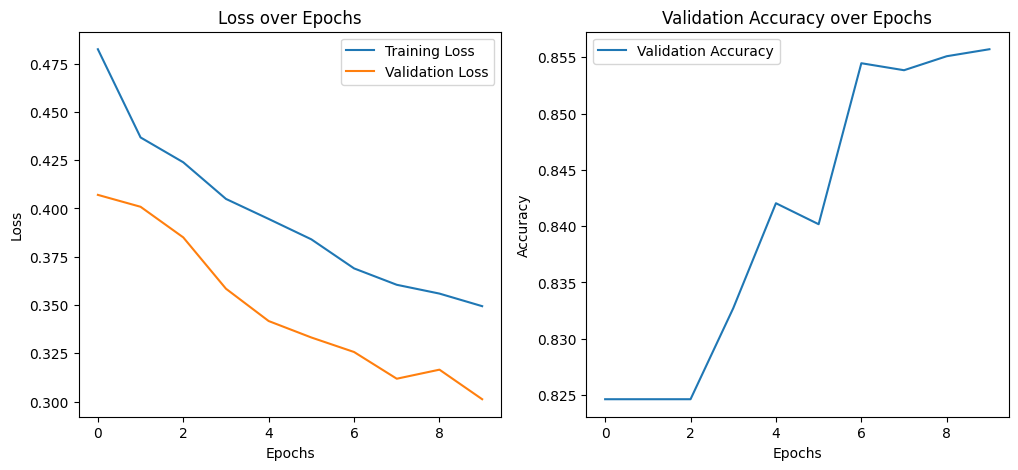

Testing params: {'hidden_size': 256, 'learning_rate': 1e-05, 'num_heads': 4, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.7087, Validation Loss: 0.6891, Validation Accuracy: 0.5187
Epoch 2/10, Train Loss: 0.6818, Validation Loss: 0.6473, Validation Accuracy: 0.5187
Epoch 3/10, Train Loss: 0.6368, Validation Loss: 0.5928, Validation Accuracy: 0.5187
Epoch 4/10, Train Loss: 0.5780, Validation Loss: 0.5305, Validation Accuracy: 0.8122
Epoch 5/10, Train Loss: 0.5193, Validation Loss: 0.4734, Validation Accuracy: 0.8190
Epoch 6/10, Train Loss: 0.4743, Validation Loss: 0.4352, Validation Accuracy: 0.8228
Epoch 7/10, Train Loss: 0.4466, Validation Loss: 0.4125, Validation Accuracy: 0.8271
Epoch 8/10, Train Loss: 0.4333, Validation Loss: 0.4009, Validation Accuracy: 0.8271
Epoch 9/10, Train Loss: 0.4260, Validation Loss: 0.3954, Validation Accuracy: 0.8277
Epoch 10/10, Train Loss: 0.4206, Validation Loss: 0.3907, Validation Accuracy: 0.8271


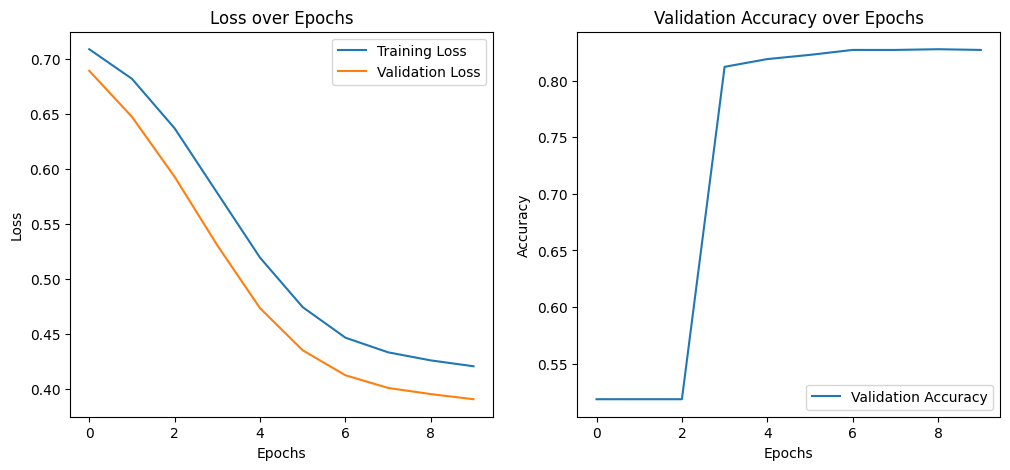

Testing params: {'hidden_size': 256, 'learning_rate': 1e-05, 'num_heads': 4, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.6262, Validation Loss: 0.5364, Validation Accuracy: 0.8246
Epoch 2/10, Train Loss: 0.4983, Validation Loss: 0.4429, Validation Accuracy: 0.8284
Epoch 3/10, Train Loss: 0.4432, Validation Loss: 0.4055, Validation Accuracy: 0.8240
Epoch 4/10, Train Loss: 0.4211, Validation Loss: 0.3859, Validation Accuracy: 0.8327
Epoch 5/10, Train Loss: 0.4059, Validation Loss: 0.3677, Validation Accuracy: 0.8352
Epoch 6/10, Train Loss: 0.3856, Validation Loss: 0.3463, Validation Accuracy: 0.8439
Epoch 7/10, Train Loss: 0.3715, Validation Loss: 0.3269, Validation Accuracy: 0.8607
Epoch 8/10, Train Loss: 0.3619, Validation Loss: 0.3189, Validation Accuracy: 0.8619
Epoch 9/10, Train Loss: 0.3561, Validation Loss: 0.3161, Validation Accuracy: 0.8619
Epoch 10/10, Train Loss: 0.3521, Validation Loss: 0.3104, Validation Accuracy: 0.8650


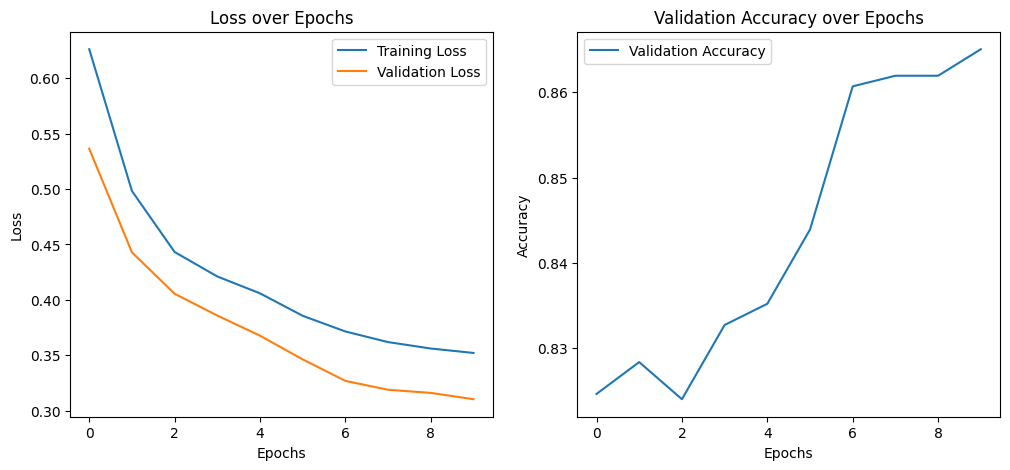

Testing params: {'hidden_size': 256, 'learning_rate': 1e-05, 'num_heads': 8, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.5977, Validation Loss: 0.4796, Validation Accuracy: 0.8296
Epoch 2/10, Train Loss: 0.4557, Validation Loss: 0.4002, Validation Accuracy: 0.8396
Epoch 3/10, Train Loss: 0.4064, Validation Loss: 0.3717, Validation Accuracy: 0.8396
Epoch 4/10, Train Loss: 0.3828, Validation Loss: 0.3450, Validation Accuracy: 0.8495
Epoch 5/10, Train Loss: 0.3681, Validation Loss: 0.3356, Validation Accuracy: 0.8476
Epoch 6/10, Train Loss: 0.3605, Validation Loss: 0.3247, Validation Accuracy: 0.8539
Epoch 7/10, Train Loss: 0.3545, Validation Loss: 0.3187, Validation Accuracy: 0.8588
Epoch 8/10, Train Loss: 0.3477, Validation Loss: 0.3125, Validation Accuracy: 0.8644
Epoch 9/10, Train Loss: 0.3432, Validation Loss: 0.3076, Validation Accuracy: 0.8657
Epoch 10/10, Train Loss: 0.3403, Validation Loss: 0.3052, Validation Accuracy: 0.8694


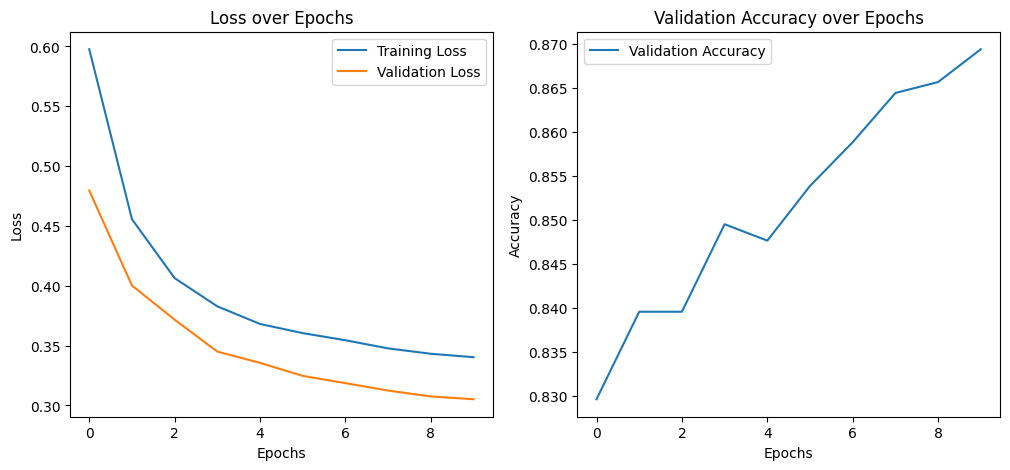

Testing params: {'hidden_size': 256, 'learning_rate': 1e-05, 'num_heads': 8, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.6921, Validation Loss: 0.6694, Validation Accuracy: 0.4813
Epoch 2/10, Train Loss: 0.6540, Validation Loss: 0.6500, Validation Accuracy: 0.4813
Epoch 3/10, Train Loss: 0.6272, Validation Loss: 0.5973, Validation Accuracy: 0.4813
Epoch 4/10, Train Loss: 0.5681, Validation Loss: 0.5204, Validation Accuracy: 0.8284
Epoch 5/10, Train Loss: 0.5099, Validation Loss: 0.4662, Validation Accuracy: 0.8259
Epoch 6/10, Train Loss: 0.4748, Validation Loss: 0.4385, Validation Accuracy: 0.8302
Epoch 7/10, Train Loss: 0.4537, Validation Loss: 0.4202, Validation Accuracy: 0.8308
Epoch 8/10, Train Loss: 0.4406, Validation Loss: 0.4106, Validation Accuracy: 0.8308
Epoch 9/10, Train Loss: 0.4332, Validation Loss: 0.4013, Validation Accuracy: 0.8315
Epoch 10/10, Train Loss: 0.4253, Validation Loss: 0.3991, Validation Accuracy: 0.8240


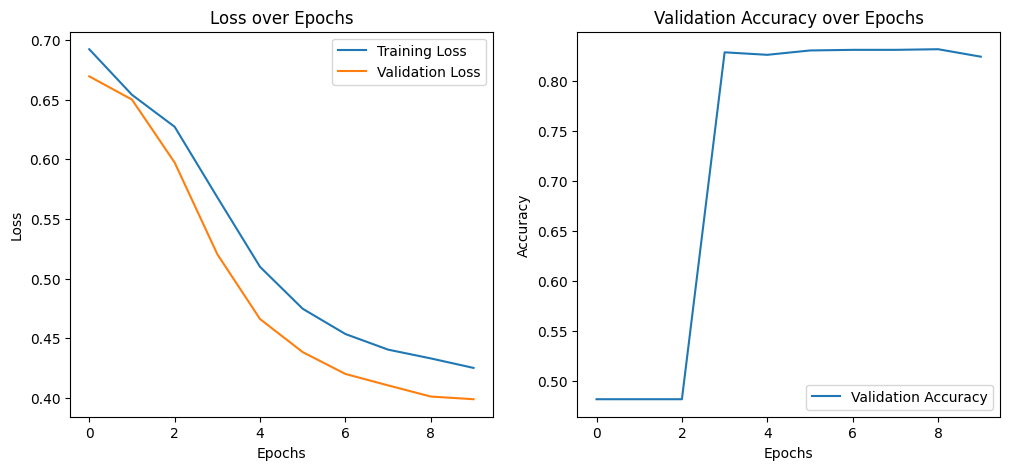

Testing params: {'hidden_size': 256, 'learning_rate': 1e-05, 'num_heads': 16, 'num_layers': 4}
Epoch 1/10, Train Loss: 0.6530, Validation Loss: 0.5623, Validation Accuracy: 0.8010
Epoch 2/10, Train Loss: 0.5041, Validation Loss: 0.4275, Validation Accuracy: 0.8197
Epoch 3/10, Train Loss: 0.4289, Validation Loss: 0.3934, Validation Accuracy: 0.8172
Epoch 4/10, Train Loss: 0.4148, Validation Loss: 0.3782, Validation Accuracy: 0.8221
Epoch 5/10, Train Loss: 0.3987, Validation Loss: 0.3618, Validation Accuracy: 0.8315
Epoch 6/10, Train Loss: 0.3913, Validation Loss: 0.3579, Validation Accuracy: 0.8302
Epoch 7/10, Train Loss: 0.3870, Validation Loss: 0.3567, Validation Accuracy: 0.8308
Epoch 8/10, Train Loss: 0.3805, Validation Loss: 0.3540, Validation Accuracy: 0.8327
Epoch 9/10, Train Loss: 0.3810, Validation Loss: 0.3540, Validation Accuracy: 0.8340
Epoch 10/10, Train Loss: 0.3779, Validation Loss: 0.3520, Validation Accuracy: 0.8277


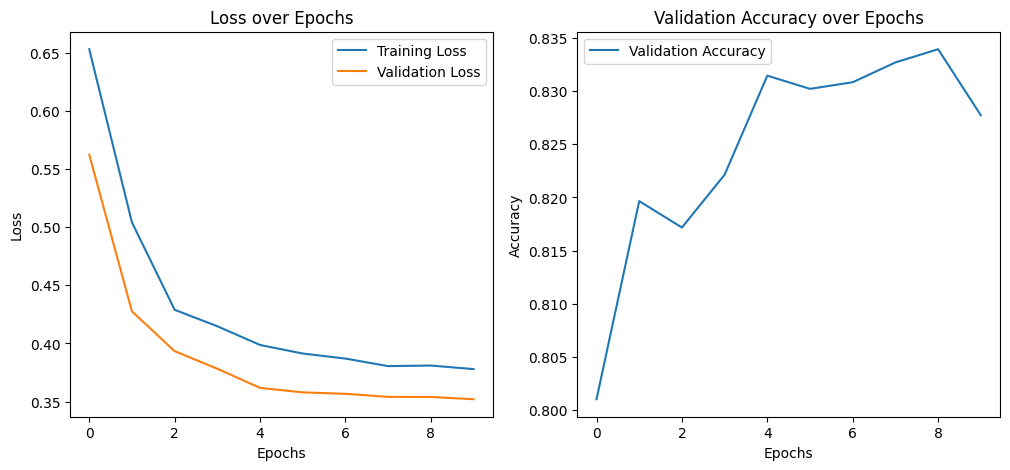

Testing params: {'hidden_size': 256, 'learning_rate': 1e-05, 'num_heads': 16, 'num_layers': 6}
Epoch 1/10, Train Loss: 0.6240, Validation Loss: 0.5196, Validation Accuracy: 0.8246
Epoch 2/10, Train Loss: 0.4814, Validation Loss: 0.4255, Validation Accuracy: 0.8252
Epoch 3/10, Train Loss: 0.4319, Validation Loss: 0.3961, Validation Accuracy: 0.8246
Epoch 4/10, Train Loss: 0.4201, Validation Loss: 0.3880, Validation Accuracy: 0.8290
Epoch 5/10, Train Loss: 0.4163, Validation Loss: 0.3849, Validation Accuracy: 0.8290
Epoch 6/10, Train Loss: 0.4141, Validation Loss: 0.3824, Validation Accuracy: 0.8308
Epoch 7/10, Train Loss: 0.4134, Validation Loss: 0.3830, Validation Accuracy: 0.8284
Epoch 8/10, Train Loss: 0.4116, Validation Loss: 0.3807, Validation Accuracy: 0.8296
Epoch 9/10, Train Loss: 0.4108, Validation Loss: 0.3812, Validation Accuracy: 0.8284
Epoch 10/10, Train Loss: 0.4111, Validation Loss: 0.3781, Validation Accuracy: 0.8321


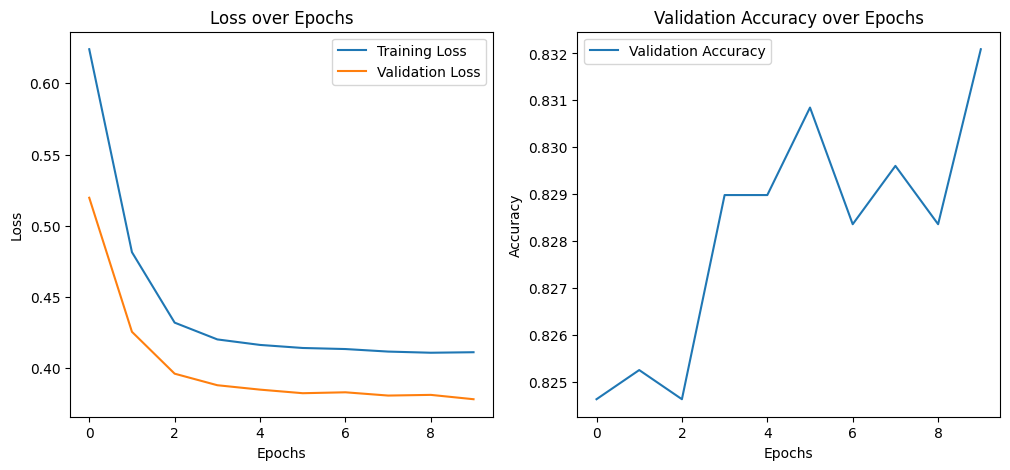



Results:

+---------------+--------------+---------------+-----------------+----------------+-----------------+--------------+
|   Hidden Size |   Num. Heads |   Num. Layers |   Learning Rate |   Accuracy (%) |   Precision (%) |   Recall (%) |
+===============+==============+===============+=================+================+=================+==============+
|           128 |           16 |             4 |          0.0001 |          88.74 |           90.12 |        86.05 |
+---------------+--------------+---------------+-----------------+----------------+-----------------+--------------+
|           256 |            4 |             4 |          0.0001 |          88.56 |           85.12 |        92.38 |
+---------------+--------------+---------------+-----------------+----------------+-----------------+--------------+
|            64 |           16 |             4 |          0.0001 |          88.5  |           86.77 |        89.79 |
+---------------+--------------+---------------+----

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_score, recall_score
import pandas as pd
from tabulate import tabulate  # Import tabulate for table formatting

# Define parameter grid
param_grid = {
    'hidden_size': [64, 128, 256],
    'num_heads': [4, 8, 16],
    'num_layers': [4, 6],
    'learning_rate': [1e-4, 1e-5]
}
results = []

for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")

    # Initialize model with the current parameters
    model = DeepNeuroPred(
        vocab_size,
        hidden_size=params['hidden_size'],
        num_heads=params['num_heads'],
        num_layers=params['num_layers'],
        num_labels=2
    )

    # Set optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['learning_rate'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Train the model
    train_model(model, train_loader, val_loader, epochs=10, optimizer=optimizer, scheduler=scheduler, device=device)

    # Evaluate the model
    accuracy, (precision, recall) = evaluate_model(model, val_loader, device, detailed_metrics=True)

    # Log results
    results.append({
        'hidden_size': params['hidden_size'],
        'num_heads': params['num_heads'],
        'num_layers': params['num_layers'],
        'learning_rate': params['learning_rate'],
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    })

# Save results to a CSV file
pd.DataFrame(results).to_csv("hyperparameter_results.csv", index=False)

# Sort results by accuracy in descending order
results = sorted(results, key=lambda x: x['accuracy'], reverse=True)

# Print results in a table format
headers = ["Hidden Size", "Num. Heads", "Num. Layers", "Learning Rate", "Accuracy (%)", "Precision (%)", "Recall (%)"]
table = []
for result in results:
    table.append([
        result['hidden_size'],
        result['num_heads'],
        result['num_layers'],
        result['learning_rate'],
        f"{result['accuracy']*100:.2f}",
        f"{result['precision']*100:.2f}",
        f"{result['recall']*100:.2f}"
    ])

# Display the table using tabulate
print("\n\nResults:\n")
print(tabulate(table, headers=headers, tablefmt="grid"))

# 10 Fold Cross Validation

Fold 1/10
Epoch 1/5, Train Loss: 0.5038, Validation Loss: 0.3616, Validation Accuracy: 0.8371
Epoch 2/5, Train Loss: 0.3606, Validation Loss: 0.3556, Validation Accuracy: 0.8346
Epoch 3/5, Train Loss: 0.3458, Validation Loss: 0.3339, Validation Accuracy: 0.8396
Epoch 4/5, Train Loss: 0.3375, Validation Loss: 0.3368, Validation Accuracy: 0.8408
Epoch 5/5, Train Loss: 0.3251, Validation Loss: 0.3228, Validation Accuracy: 0.8507


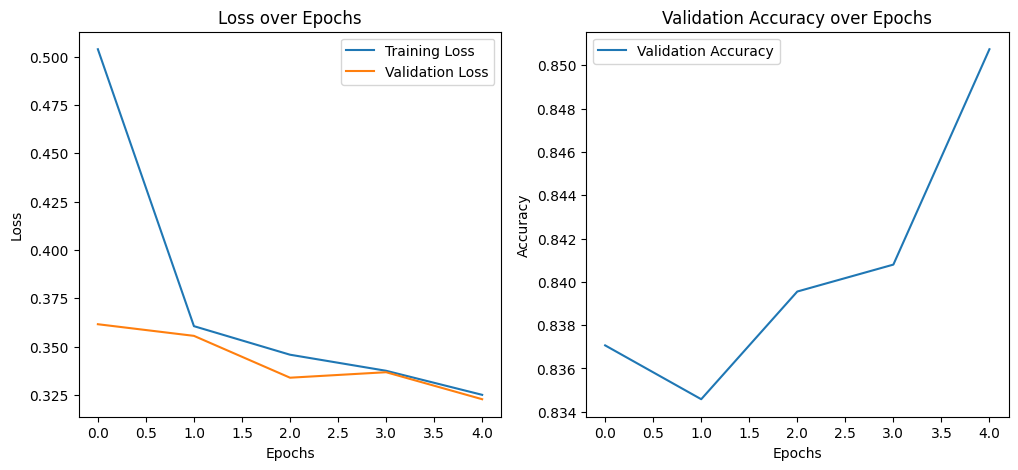

Fold 1 - Accuracy: 0.8507, Precision: 0.8508, Recall: 0.8507, F1-Score: 0.8505
Fold 2/10
Epoch 1/5, Train Loss: 0.4925, Validation Loss: 0.3657, Validation Accuracy: 0.8346
Epoch 2/5, Train Loss: 0.3745, Validation Loss: 0.3349, Validation Accuracy: 0.8470
Epoch 3/5, Train Loss: 0.3564, Validation Loss: 0.3203, Validation Accuracy: 0.8595
Epoch 4/5, Train Loss: 0.3424, Validation Loss: 0.3379, Validation Accuracy: 0.8545
Epoch 5/5, Train Loss: 0.3319, Validation Loss: 0.2991, Validation Accuracy: 0.8669


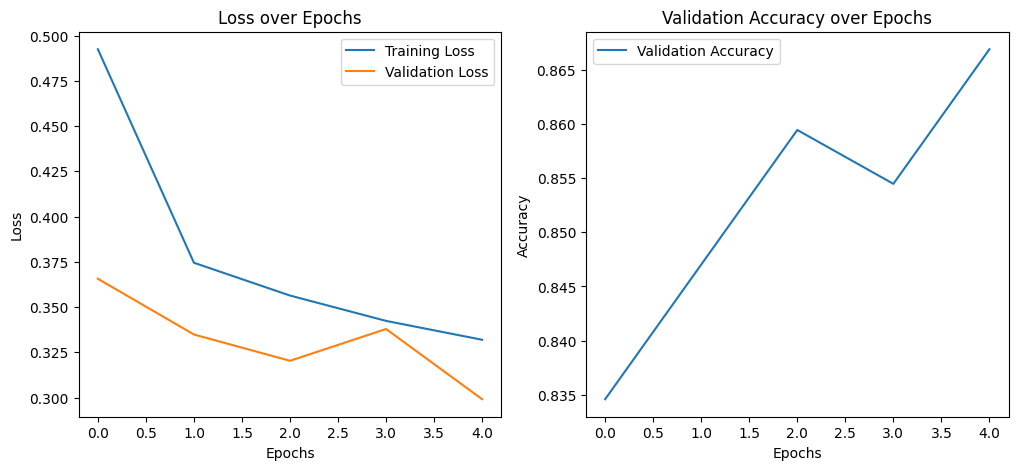

Fold 2 - Accuracy: 0.8669, Precision: 0.8699, Recall: 0.8669, F1-Score: 0.8664
Fold 3/10
Epoch 1/5, Train Loss: 0.5210, Validation Loss: 0.3966, Validation Accuracy: 0.8433
Epoch 2/5, Train Loss: 0.4126, Validation Loss: 0.3890, Validation Accuracy: 0.8271
Epoch 3/5, Train Loss: 0.4097, Validation Loss: 0.3859, Validation Accuracy: 0.8284
Epoch 4/5, Train Loss: 0.4077, Validation Loss: 0.3774, Validation Accuracy: 0.8321
Epoch 5/5, Train Loss: 0.4039, Validation Loss: 0.3715, Validation Accuracy: 0.8321


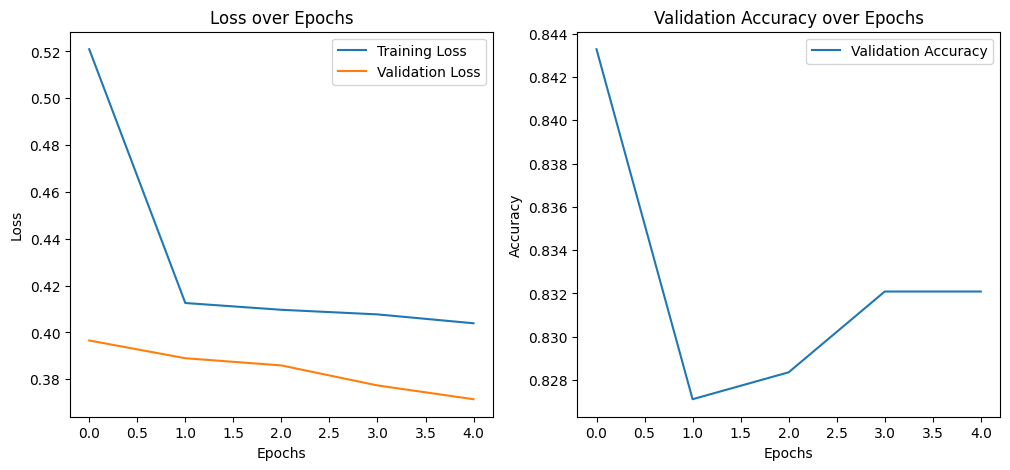

Fold 3 - Accuracy: 0.8321, Precision: 0.8533, Recall: 0.8321, F1-Score: 0.8293
Fold 4/10
Epoch 1/5, Train Loss: 0.5162, Validation Loss: 0.3667, Validation Accuracy: 0.8308
Epoch 2/5, Train Loss: 0.3595, Validation Loss: 0.3378, Validation Accuracy: 0.8445
Epoch 3/5, Train Loss: 0.3402, Validation Loss: 0.3300, Validation Accuracy: 0.8470
Epoch 4/5, Train Loss: 0.3268, Validation Loss: 0.3246, Validation Accuracy: 0.8632
Epoch 5/5, Train Loss: 0.3167, Validation Loss: 0.3142, Validation Accuracy: 0.8532


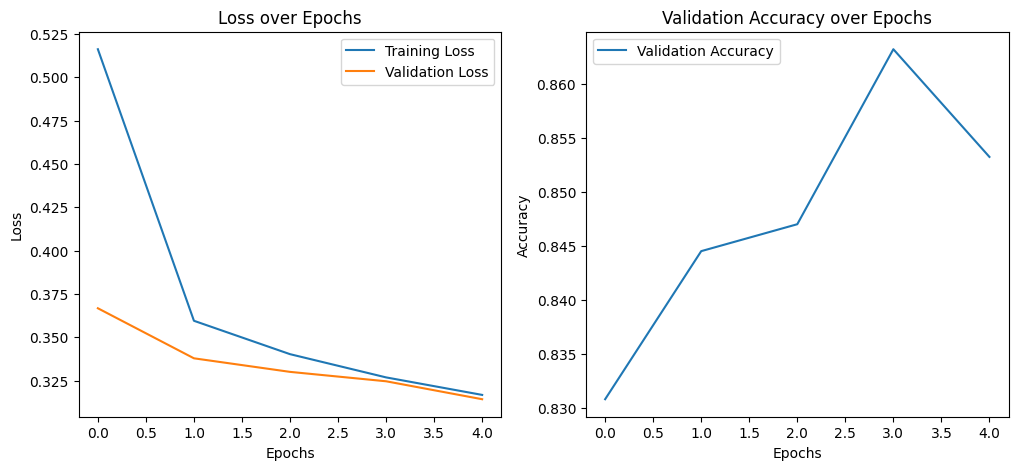

Fold 4 - Accuracy: 0.8532, Precision: 0.8600, Recall: 0.8532, F1-Score: 0.8530
Fold 5/10
Epoch 1/5, Train Loss: 0.5019, Validation Loss: 0.4490, Validation Accuracy: 0.7873
Epoch 2/5, Train Loss: 0.3812, Validation Loss: 0.4114, Validation Accuracy: 0.8172
Epoch 3/5, Train Loss: 0.3549, Validation Loss: 0.3842, Validation Accuracy: 0.8209
Epoch 4/5, Train Loss: 0.3433, Validation Loss: 0.3847, Validation Accuracy: 0.8234
Epoch 5/5, Train Loss: 0.3338, Validation Loss: 0.3644, Validation Accuracy: 0.8371


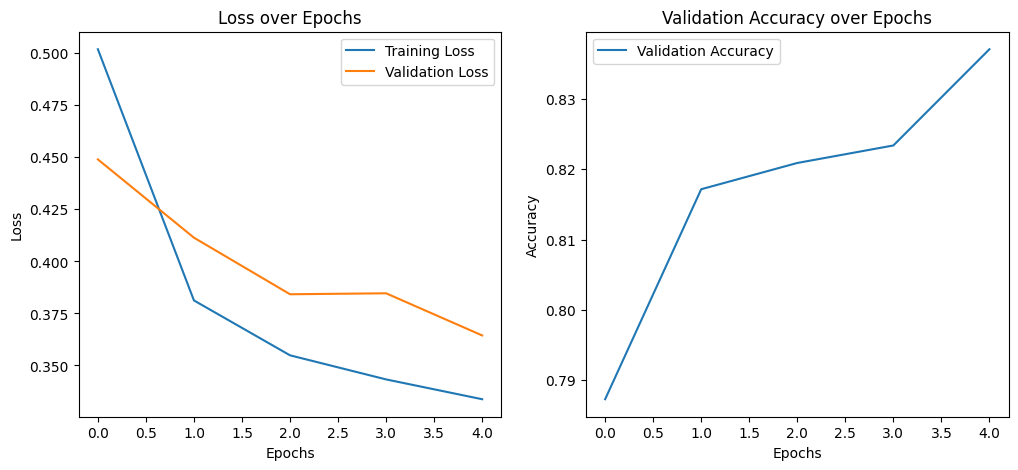

Fold 5 - Accuracy: 0.8371, Precision: 0.8381, Recall: 0.8371, F1-Score: 0.8369
Fold 6/10
Epoch 1/5, Train Loss: 0.5032, Validation Loss: 0.3886, Validation Accuracy: 0.8371
Epoch 2/5, Train Loss: 0.3899, Validation Loss: 0.3688, Validation Accuracy: 0.8358
Epoch 3/5, Train Loss: 0.3613, Validation Loss: 0.3578, Validation Accuracy: 0.8433
Epoch 4/5, Train Loss: 0.3484, Validation Loss: 0.3304, Validation Accuracy: 0.8595
Epoch 5/5, Train Loss: 0.3408, Validation Loss: 0.3215, Validation Accuracy: 0.8694


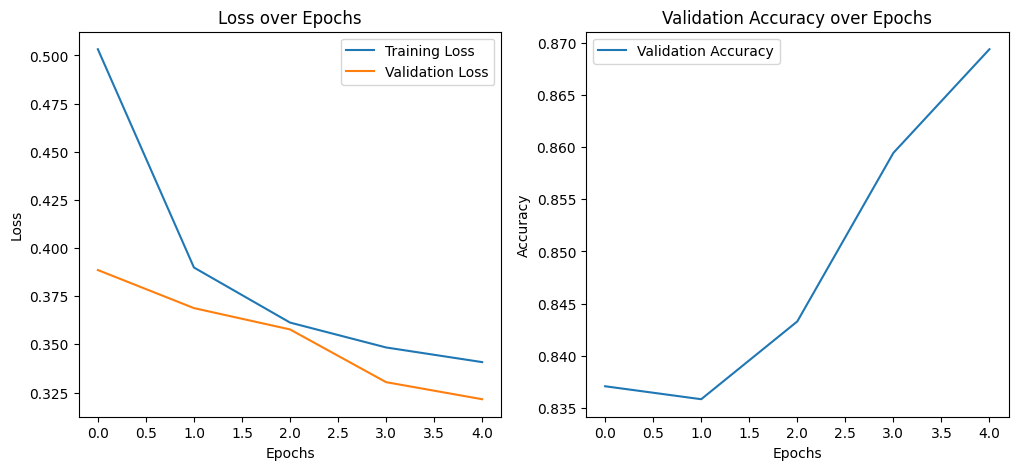

Fold 6 - Accuracy: 0.8694, Precision: 0.8701, Recall: 0.8694, F1-Score: 0.8692
Fold 7/10
Epoch 1/5, Train Loss: 0.5204, Validation Loss: 0.4029, Validation Accuracy: 0.8147
Epoch 2/5, Train Loss: 0.3775, Validation Loss: 0.3816, Validation Accuracy: 0.8259
Epoch 3/5, Train Loss: 0.3566, Validation Loss: 0.3677, Validation Accuracy: 0.8209
Epoch 4/5, Train Loss: 0.3426, Validation Loss: 0.3660, Validation Accuracy: 0.8296
Epoch 5/5, Train Loss: 0.3334, Validation Loss: 0.3415, Validation Accuracy: 0.8483


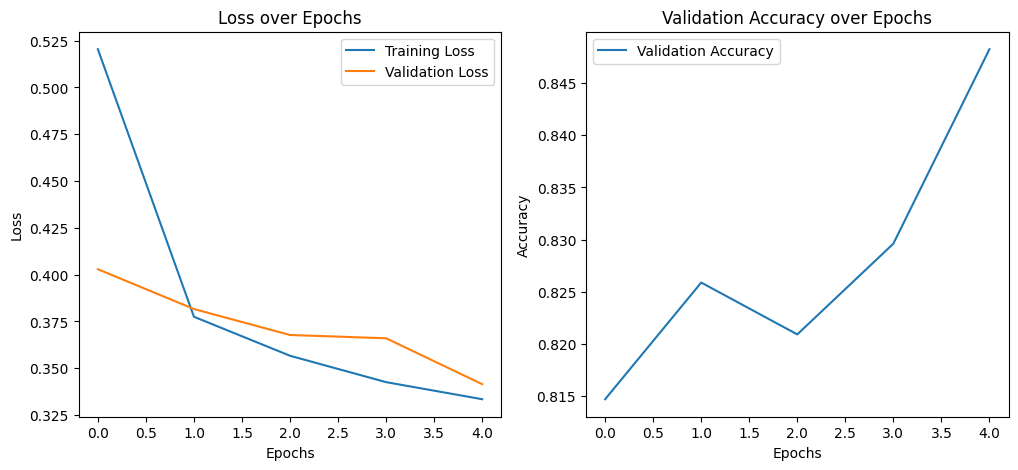

Fold 7 - Accuracy: 0.8483, Precision: 0.8485, Recall: 0.8483, F1-Score: 0.8482
Fold 8/10
Epoch 1/5, Train Loss: 0.5647, Validation Loss: 0.4214, Validation Accuracy: 0.8147
Epoch 2/5, Train Loss: 0.4016, Validation Loss: 0.3823, Validation Accuracy: 0.8259
Epoch 3/5, Train Loss: 0.3642, Validation Loss: 0.3661, Validation Accuracy: 0.8284
Epoch 4/5, Train Loss: 0.3535, Validation Loss: 0.3616, Validation Accuracy: 0.8445
Epoch 5/5, Train Loss: 0.3463, Validation Loss: 0.3610, Validation Accuracy: 0.8296


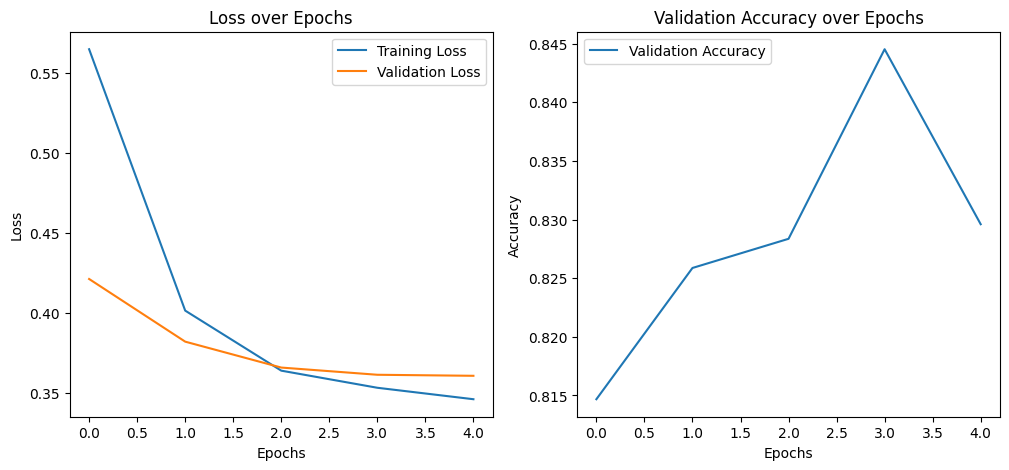

Fold 8 - Accuracy: 0.8296, Precision: 0.8297, Recall: 0.8296, F1-Score: 0.8296
Fold 9/10
Epoch 1/5, Train Loss: 0.4916, Validation Loss: 0.3849, Validation Accuracy: 0.8344
Epoch 2/5, Train Loss: 0.3599, Validation Loss: 0.3621, Validation Accuracy: 0.8468
Epoch 3/5, Train Loss: 0.3427, Validation Loss: 0.3563, Validation Accuracy: 0.8518
Epoch 4/5, Train Loss: 0.3288, Validation Loss: 0.3332, Validation Accuracy: 0.8605
Epoch 5/5, Train Loss: 0.3169, Validation Loss: 0.3304, Validation Accuracy: 0.8518


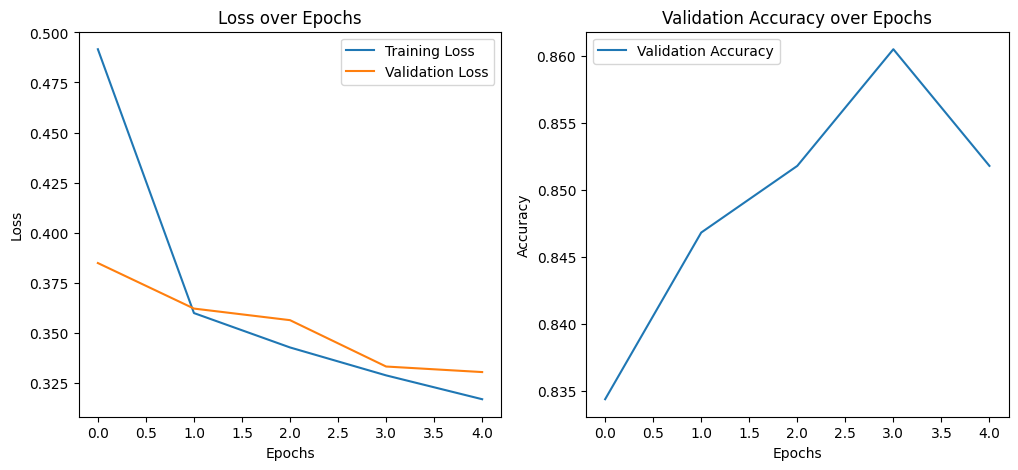

Fold 9 - Accuracy: 0.8518, Precision: 0.8602, Recall: 0.8518, F1-Score: 0.8513
Fold 10/10
Epoch 1/5, Train Loss: 0.4815, Validation Loss: 0.3732, Validation Accuracy: 0.8356
Epoch 2/5, Train Loss: 0.3616, Validation Loss: 0.3478, Validation Accuracy: 0.8493
Epoch 3/5, Train Loss: 0.3466, Validation Loss: 0.3390, Validation Accuracy: 0.8568
Epoch 4/5, Train Loss: 0.3335, Validation Loss: 0.3352, Validation Accuracy: 0.8643
Epoch 5/5, Train Loss: 0.3216, Validation Loss: 0.3201, Validation Accuracy: 0.8680


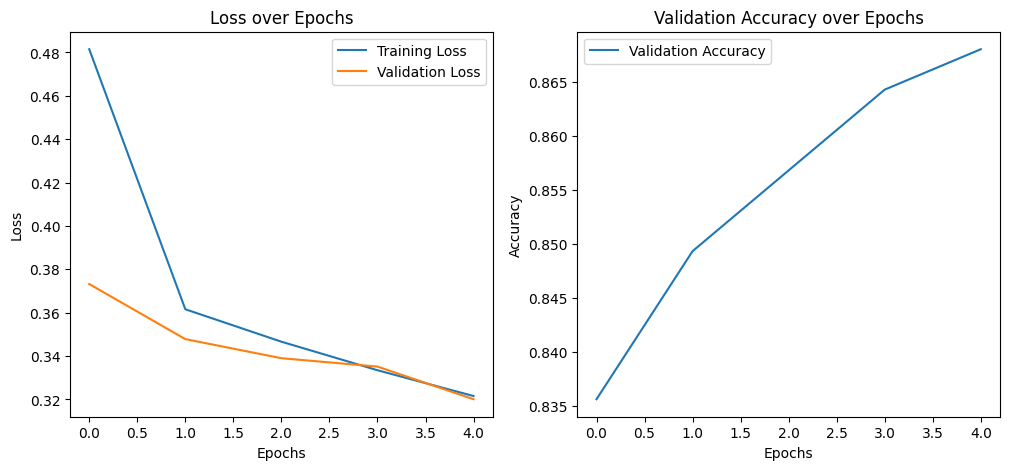

Fold 10 - Accuracy: 0.8680, Precision: 0.8688, Recall: 0.8680, F1-Score: 0.8677

Cross-Validation Results:
Fold 1: {'accuracy': 0.8507462686567164, 'precision': 0.8508363783442727, 'recall': 0.8507462686567164, 'f1': 0.8505314749493352}
Fold 2: {'accuracy': 0.8669154228855721, 'precision': 0.8699416370958276, 'recall': 0.8669154228855721, 'f1': 0.8663572871319118}
Fold 3: {'accuracy': 0.832089552238806, 'precision': 0.8532862473347548, 'recall': 0.832089552238806, 'f1': 0.82934253645722}
Fold 4: {'accuracy': 0.8532338308457711, 'precision': 0.859953730859141, 'recall': 0.8532338308457711, 'f1': 0.8529975567969544}
Fold 5: {'accuracy': 0.8370646766169154, 'precision': 0.8380569017863054, 'recall': 0.8370646766169154, 'f1': 0.8368730405774382}
Fold 6: {'accuracy': 0.8694029850746269, 'precision': 0.870145807300751, 'recall': 0.8694029850746269, 'f1': 0.8691771415433851}
Fold 7: {'accuracy': 0.8482587064676617, 'precision': 0.8484681912379244, 'recall': 0.8482587064676617, 'f1': 0.8481740

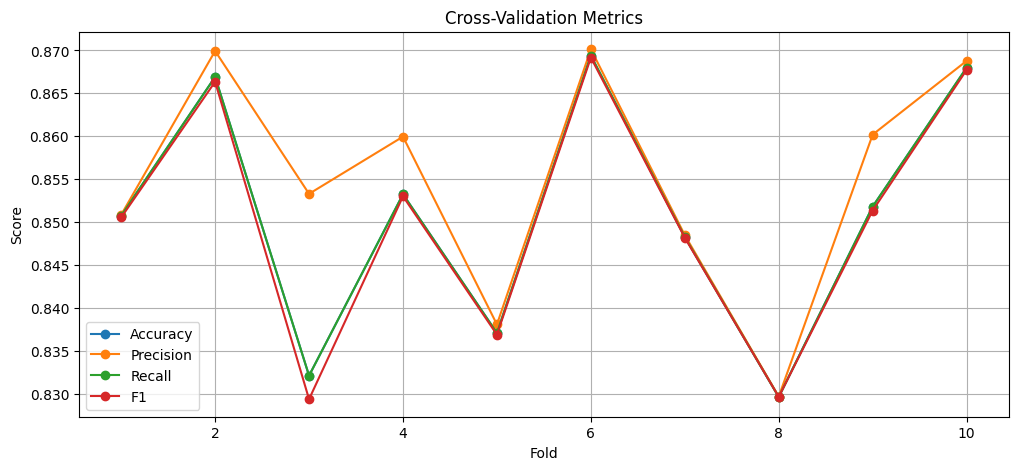

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define the number of folds for cross-validation
k_folds = 10

# Define the KFold object
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store metrics for each fold
fold_metrics = []

# Begin cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(train_texts)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Split the data
    train_data = NeuropeptideDataset(train_texts[train_idx], train_labels[train_idx])
    val_data = NeuropeptideDataset(train_texts[val_idx], train_labels[val_idx])

    train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

    # Initialize the model, optimizer, and scheduler
    model = DeepNeuroPred(vocab_size=tokenizer.vocab_size, num_labels=2).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Train the model
    train_model(model, train_loader, val_loader, epochs=5, optimizer=optimizer, scheduler=scheduler, device=device)

    # Evaluate on validation set
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs, _ = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Store metrics
    fold_metrics.append({'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})
    print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Summarize results
print("\nCross-Validation Results:")
for i, metrics in enumerate(fold_metrics):
    print(f"Fold {i + 1}: {metrics}")

# Calculate average metrics
avg_metrics = {key: np.mean([metrics[key] for metrics in fold_metrics]) for key in fold_metrics[0]}
print("\nAverage Metrics:")
print(f"Accuracy: {avg_metrics['accuracy']:.4f}")
print(f"Precision: {avg_metrics['precision']:.4f}")
print(f"Recall: {avg_metrics['recall']:.4f}")
print(f"F1-Score: {avg_metrics['f1']:.4f}")

# Generate summary plots
metrics_df = pd.DataFrame(fold_metrics)

plt.figure(figsize=(12, 5))
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.plot(range(1, k_folds + 1), metrics_df[metric], label=metric.capitalize(), marker='o')

plt.title("Cross-Validation Metrics")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

# Results

In [ ]:
import random

def print_sample_predictions(model, test_loader, device, tokenizer, num_samples=5):
    model.eval()
    samples = []
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs, _ = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            for i in range(len(inputs)):
                samples.append({
                    "input": tokenizer.decode(inputs[i].cpu().numpy(), skip_special_tokens=True),
                    "original_label": labels[i].item(),
                    "predicted_label": preds[i].item()
                })

    # Randomly sample and print the selected number of samples
    print("\nSample Predictions:")
    for sample in random.sample(samples, num_samples):
        print(f"Input: {sample['input']}")
        print(f"Original Label: {sample['original_label']} - Predicted Label: {sample['predicted_label']}\n")

# Example usage
print_sample_predictions(model, test_loader, device, tokenizer)



Sample Predictions:
Input: K P S G F L G M R
Original Label: 1 - Predicted Label: 1

Input: M D D H H V W L E Q R L
Original Label: 0 - Predicted Label: 0

Input: M V N L A C E Q H I N I L H L Q H G N
Original Label: 0 - Predicted Label: 0

Input: M F L L L K L S V A T
Original Label: 0 - Predicted Label: 0

Input: K K I D T R T G K T M E K T E K K I E L S L K N M K T A T
Original Label: 0 - Predicted Label: 0

